# Task 3 - Cluster Analysis - Hard Clustering

Getting a deep understanding of how customers use your mobility service is crucial. As an example, for marketing purposes, or managerial decisions. One widely adopted approach to understand customers’ behavior is to find prevalent usage/trip clusters. 

**Tasks:** Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods:** Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data. 

Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

In this section we do cluster analysis on taxi data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).
We try to find pattern in the data, identify them and in addition to that we are interested in labeling these cluster patterns.

We are going to do different cluster analysis:

- customer types based on different features
- location based clustering

In general we do a hard and soft clustering, but in this part we perform the soft clustering. The soft clustering we use is the Gaussian Mixture Model.

Our procedure in this part is structured in the following way. For every different cluster analysis we do the following:

- small preprocessing
- deciding for the number of clusters
- process cluster analysis
- analyze und label the clusters

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
import math
from sklearn.metrics import mean_squared_error
sns.set_theme()

import sklearn
from sklearn.cluster import KMeans
import folium

In [2]:
# import datasets
dfChicago = pd.read_csv("..\data\datasets\df_chicago.csv.zip")

## Functions defined for cluster analysis

### 1) Scaling function

#### Data scaling function:

In [9]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    dfChicago_clu_X_locations_scaled = scaler.fit_transform(df1)
    dfChicago_clu_X_locations_scaled_df = pd.DataFrame(dfChicago_clu_X_locations_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return dfChicago_clu_X_locations_scaled_df



### 2) k-means++ Cluster Functions:

In [10]:
def get_clusters_and_losses(input_data):
    
    clusters_dfChicago_clu_X = []
    losses_dfChicago_clu_X = []

    for k in range(20):
        model_clu_X = KMeans(n_clusters=k+1,n_init=1)
        model_clu_X.fit(input_data)
        clusters_dfChicago_clu_X.append(k+1)
        losses_dfChicago_clu_X.append(model_clu_X.inertia_)
        
    return clusters_dfChicago_clu_X, losses_dfChicago_clu_X

In [11]:
# method to plot the most valuable number of clusters
def plot_best_fitting_number_of_clusters(input_data, title_info):
    
    fig = plt.figure(figsize=(16,8))

    plt.subplot(1, 2, 1)

    clusters, losses = get_clusters_and_losses(input_data)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.title(f"Number of Clusters {title_info}")

    plt.subplot(1, 2, 2)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,12])
    plt.title(f"Number of Clusters {title_info} - Deeper Look")

    plt.show()

### 3) Plotting functions:

#### Plot cluster information:

In [12]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

#### Plot clusters (scatterplot):

In [ ]:
def plot_cluster_scatter(x_column, y_column, df, x_label, y_label):

    colors = {
        2: '#16C835', #green
        1: '#FF7C00',#orange
        4: '#8B2BE2',#violet
        5: '#843C0C',#brown
        0: '#023EFF',#blue
        6: '#FF1493',#rosa
        3:'#FF0000',#red
        7:'#808080'#grey
        # Add more colors for other clusters if needed
    }

    # Create the scatter plot
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    # Use hue parameter to color the data points based on the 'cluster' column
    sns.scatterplot(x=x_column, y=y_column,data=df,hue='cluster', palette=colors)

    # Add labels and legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

    # Move the legend outside and above the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
    # Show the plot
    plt.show()

#### Plot scatter with convex hulls:

In [14]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()


### 4) Functions for calculations:

#### Function for quantiles

In [42]:
def get_quantiles_of_clusters(df, n_cluster, cluster_feature):
    
    # create dataframe to store values of calculated quantiles and return df at the end of the method
    dfChicago_quantiles = pd.DataFrame(df)
    # empty all values inside newly created df to just receive columns
    dfChicago_quantiles = dfChicago_quantiles[0:0]

    for cluster in range(0,n_cluster):
        # get 0.25 quantiles
        dict_quantiles_0_25 = df[df[cluster_feature]==cluster].quantile(q=0.25).to_dict()
        # get 0.75 quantiles
        dict_quantiles_0_75 = df[df[cluster_feature]==cluster].quantile(q=0.75).to_dict()
        # round all entries in dictionaries to one decimal place
        dfQuantiles_0_25 = pd.DataFrame(dict_quantiles_0_25, index=[0]).round(2)
        dfQuantiles_0_75 = pd.DataFrame(dict_quantiles_0_75, index=[0]).round(2)
        # parse all values in newly created dfs to strings
        dfQuantiles_0_25 = dfQuantiles_0_25.astype(str)
        dfQuantiles_0_75 = dfQuantiles_0_75.astype(str)
        # combine both quantile dataframes into one interval dataframe
        dfQuantiles_interval = dfQuantiles_0_25 + " - " + dfQuantiles_0_75
        dfQuantiles_interval['Amount Trips in Cluster'] = df[df[cluster_feature]==cluster][cluster_feature].count().astype(int)
        dfQuantiles_interval['Percentage'] = (df[df[cluster_feature]==cluster][cluster_feature].count()/len(df)).round(4)*100
        # concatenate the quantiles row after row
        dfChicago_quantiles = pd.concat([dfChicago_quantiles, dfQuantiles_interval.loc[dfQuantiles_interval.index.values == 0]])
        
    # lastly styling the output dataframe (dropping unnecessary column, resetting the index, giving "Cluster" as index column name)
    dfChicago_quantiles.drop(columns=[cluster_feature], inplace=True)
    dfChicago_quantiles.reset_index(drop=True, inplace=True)
    dfChicago_quantiles = dfChicago_quantiles.rename_axis('Cluster')    
    
    return dfChicago_quantiles

### 5) Functions for mapping clusters on city map

In [ ]:
def get_hex_ids_for_cluster_and_resolution(df, cluster_number, resolution):
    # Filter hex IDs for the specified cluster and resolution
    # Group hex IDs by cluster
    grouped_h3_hex_id = df.groupby('cluster_number')[resolution].apply(set).reset_index()
    
    # Get the list of hex IDs for clusters
    hex_ids_for_clusters = grouped_h3_hex_id[grouped_h3_hex_id['cluster_number'] == cluster_number][resolution].iloc[0]
    
    return hex_ids_for_clusters

In [ ]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

<hr style="border: 1px solid #8888;">

## Preprocessing

### Preprocessing for clustering: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

To better interpret and analzye the clusters after processing, we convert the `Trip_Seconds` to `Trip_Minutes`. On the one hand we do this simply because minutes are easier to evaluate and on the other hand because the `Trip_Seconds` are always in 60 second-steps anyway.

In [ ]:
df_chicago['Trip_Minutes'] = df_chicago['Trip_Seconds']/60
df_chicago.drop(['Trip_Seconds'], axis = 1,inplace =True)

In [ ]:
df_chicago = df_chicago[(df_chicago['Trip_Miles'] < df_chicago['Trip_Miles'].quantile(0.95))]
df_chicago = df_chicago[(df_chicago['Trip_Minutes'] < df_chicago['Trip_Minutes'].quantile(0.95))]

In [ ]:
# Drop unrealistic fast trips
df_chicago["velocity"] = (df_chicago["Trip_Miles"]/(df_chicago["Trip_Minutes"]/60)).round(2)
df_chicago = df_chicago[(df_chicago['velocity'] < df_chicago['velocity'].quantile(0.95))]
df_chicago = df_chicago[(df_chicago['velocity'] > df_chicago['velocity'].quantile(0.05))]
df_chicago = df_chicago.drop(['velocity'], axis = 1)

In [ ]:
df_chicago.reset_index(inplace = True)

In [ ]:
df_chicago_cluster = df_chicago[['start_time_hourly','Trip_Minutes',"Trip_Miles"]]
df_chicago_cluster

### Preprocessing for location based clustering: 

#### Creating `distance_to_city_center_pickup` and `distance_to_city_center_dropoff`

In [4]:
#pip install dask

In [5]:
import dask.dataframe as dd
import math

# Coordinates of the city center of chicogo according to https://www.findlatitudeandlongitude.com/l/Chicago+City+centre/5712575/
chicago_city_center = (41.879519, -87.633026)

# Haversine function using Dask's map_partitions for distances in miles
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [6]:
ddfChicago = dd.from_pandas(pd.DataFrame(dfChicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_pickup'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Pickup_Centroid_Latitude'], df['Pickup_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
dfChicago = ddfChicago.compute()
dfChicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,datetime,humidity,temperature_celsius,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res,distance_to_city_center_pickup
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:00:00,900.0,2.7,NaN,NaN,28.0,8.0,...,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664ca91fffff,872664ca9ffffff,862664cafffffff,1.614272
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664c12bfffff,872664c12ffffff,862664c17ffffff,3.617721
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:00:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664ca11fffff,872664ca1ffffff,862664ca7ffffff,4.476686
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01 00:00:00,180.0,1.0,NaN,NaN,24.0,24.0,...,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664cac3fffff,872664cacffffff,862664cafffffff,2.685629
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664c1adfffff,872664c1affffff,862664c1fffffff,0.495382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,2013-12-31 23:00:00,2014-01-01 00:00:00,540.0,1.4,1.703108e+10,1.703184e+10,8.0,8.0,...,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,0.893287
8974516,9bb135881fb88cd37521eddacd3003d6e6642e8f,7b1ac8aace3932ce8b4302cc292a88c6d6f0446ea8134c...,2013-12-31 23:00:00,2014-01-01 00:00:00,1860.0,5.9,1.703108e+10,1.703106e+10,8.0,6.0,...,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,1.401331
8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,2013-12-31 23:00:00,2014-01-01 00:00:00,720.0,2.0,1.703132e+10,1.703133e+10,32.0,33.0,...,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664c1e3fffff,872664c1effffff,862664c1fffffff,0.725199
8974518,cf906408921ec94acfed42add2165ab0f52fe9b7,1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...,2013-12-31 23:00:00,2013-12-31 23:00:00,660.0,3.5,1.703108e+10,1.703184e+10,8.0,33.0,...,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664c1ebfffff,872664c1effffff,862664c1fffffff,1.344327


In [7]:
ddfChicago = dd.from_pandas(pd.DataFrame(dfChicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_dropoff'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Dropoff_Centroid_Latitude'], df['Dropoff_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
dfChicago = ddfChicago.compute()
dfChicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,humidity,temperature_celsius,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res,distance_to_city_center_pickup,distance_to_city_center_dropoff
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:00:00,900.0,2.7,NaN,NaN,28.0,8.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca91fffff,872664ca9ffffff,862664cafffffff,1.614272,1.387700
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c12bfffff,872664c12ffffff,862664c17ffffff,3.617721,3.548918
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:00:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca11fffff,872664ca1ffffff,862664ca7ffffff,4.476686,6.577887
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01 00:00:00,180.0,1.0,NaN,NaN,24.0,24.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664cac3fffff,872664cacffffff,862664cafffffff,2.685629,2.685629
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c1adfffff,872664c1affffff,862664c1fffffff,0.495382,0.587129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,2013-12-31 23:00:00,2014-01-01 00:00:00,540.0,1.4,1.703108e+10,1.703184e+10,8.0,8.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,0.893287,1.959038
8974516,9bb135881fb88cd37521eddacd3003d6e6642e8f,7b1ac8aace3932ce8b4302cc292a88c6d6f0446ea8134c...,2013-12-31 23:00:00,2014-01-01 00:00:00,1860.0,5.9,1.703108e+10,1.703106e+10,8.0,6.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,1.401331,4.414539
8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,2013-12-31 23:00:00,2014-01-01 00:00:00,720.0,2.0,1.703132e+10,1.703133e+10,32.0,33.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e3fffff,872664c1effffff,862664c1fffffff,0.725199,1.609951
8974518,cf906408921ec94acfed42add2165ab0f52fe9b7,1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...,2013-12-31 23:00:00,2013-12-31 23:00:00,660.0,3.5,1.703108e+10,1.703184e+10,8.0,33.0,...,89.0,-11.00,217.0,1.0,mist,882664c1ebfffff,872664c1effffff,862664c1fffffff,1.344327,2.141079


<hr style="border: 1px solid #8888;">

## 3.1 First Cluster Analysis: `start_time_hourly`

In [15]:
# Feature selection
dfChicago_clu_start_time = dfChicago[['start_time_hourly']]
dfChicago_clu_start_time

,start_time_hourly
0,0
1,0
2,0
3,0
4,0
...,...
8974515,23
8974516,23
8974517,23
8974518,23


#### Scaling the Data

In [16]:
# Scaling the data
dfChicago_clu_start_time_scaled = scaling_data(dfChicago_clu_start_time)

### 3.1.1 Validation of Number of Clusters

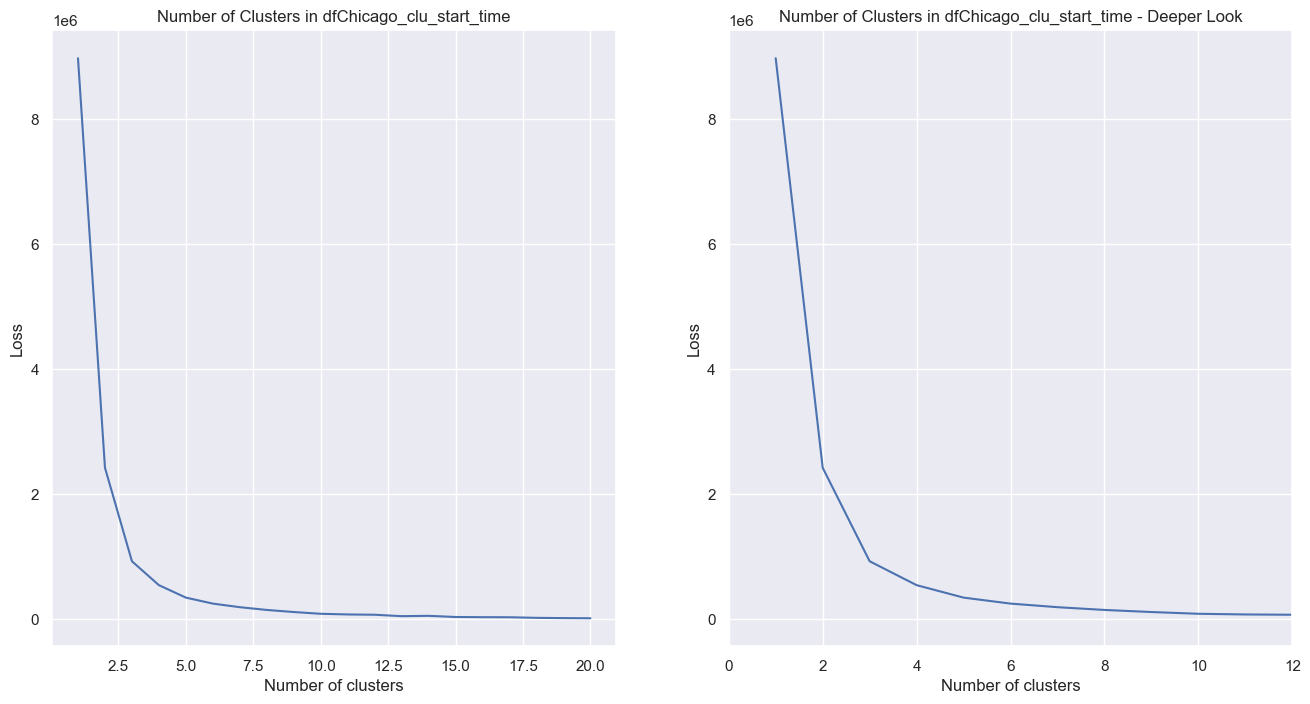

In [17]:
plot_best_fitting_number_of_clusters(dfChicago_clu_start_time_scaled, "in dfChicago_clu_start_time")

### 3.1.2 Computing Clusters with k-means++

In [18]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_start_time_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [19]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_start_time_scaled)

In [20]:
# creating a column for the calculated clusters

dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_start_time

C:\Users\jonas\AppData\Local\Temp\ipykernel_10584\1040107666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters


,start_time_hourly,cluster_number
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
8974515,23,0
8974516,23,0
8974517,23,0
8974518,23,0


### 3.1.3 Analyzing & Labeling Clusters

In [21]:
dfChicago_clu_start_time[dfChicago_clu_start_time['cluster_number']==0]['cluster_number'].count()

4195483

C:\Users\jonas\AppData\Local\Temp\ipykernel_10584\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


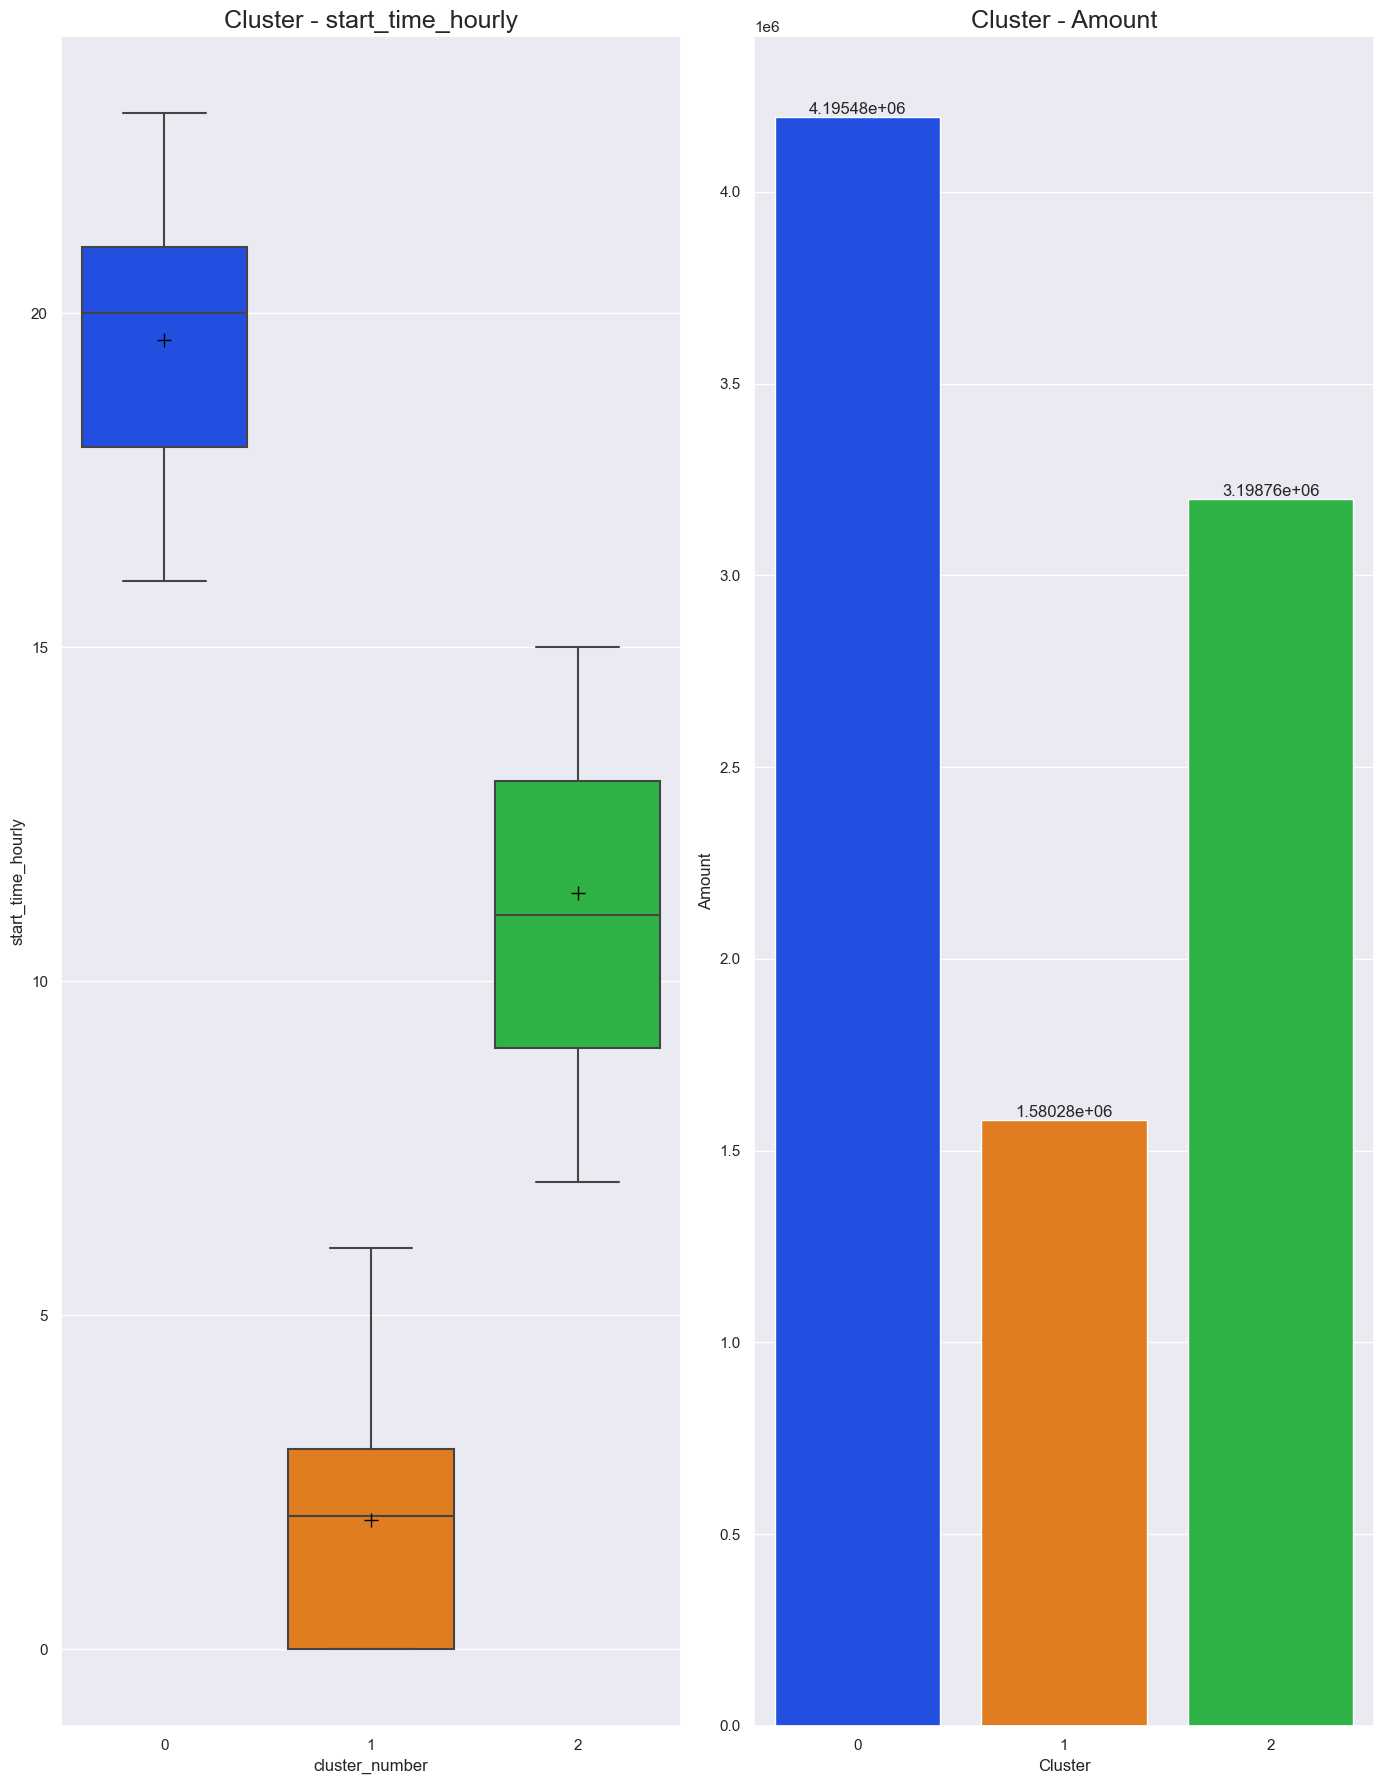

In [22]:
plot_information_about_clusters(dfChicago_clu_start_time, ['start_time_hourly'], 'cluster_number')

In [23]:
dfChicago_clu_start_time_quantiles = get_quantiles_of_clusters(dfChicago_clu_start_time, 3, 'cluster_number')
dfChicago_clu_start_time_quantiles.sort_values(by=['start_time_hourly'], ascending=False)

,start_time_hourly,Amount Trips in Cluster,Percentage
Cluster,,,
2,9.0 - 13.0,3198762.0,35.64
0,18.0 - 21.0,4195483.0,46.75
1,0.0 - 3.0,1580275.0,17.61


In [24]:
label_names = {'0': "Evening Commuters", 
               '1': "Night Riders - Party People",
               '2': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)
dfChicago_clu_start_time = dfChicago_clu_start_time.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_10584\788367742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)


In [25]:
dfChicago_clu_start_time_index = dfChicago_clu_start_time
dfChicago_clu_start_time_index['Trip_Index'] = dfChicago_clu_start_time_index.index
dfChicago_clu_start_time_index

,start_time_hourly,cluster_number,Cluster_Label,Trip_Index
0,0,1,Night Riders - Party People,0
1,0,1,Night Riders - Party People,1
2,0,1,Night Riders - Party People,2
3,0,1,Night Riders - Party People,3
4,0,1,Night Riders - Party People,4
...,...,...,...,...
8974515,23,0,Evening Commuters,8974515
8974516,23,0,Evening Commuters,8974516
8974517,23,0,Evening Commuters,8974517
8974518,23,0,Evening Commuters,8974518


### 3.1.4 Plotting the Clustering Results

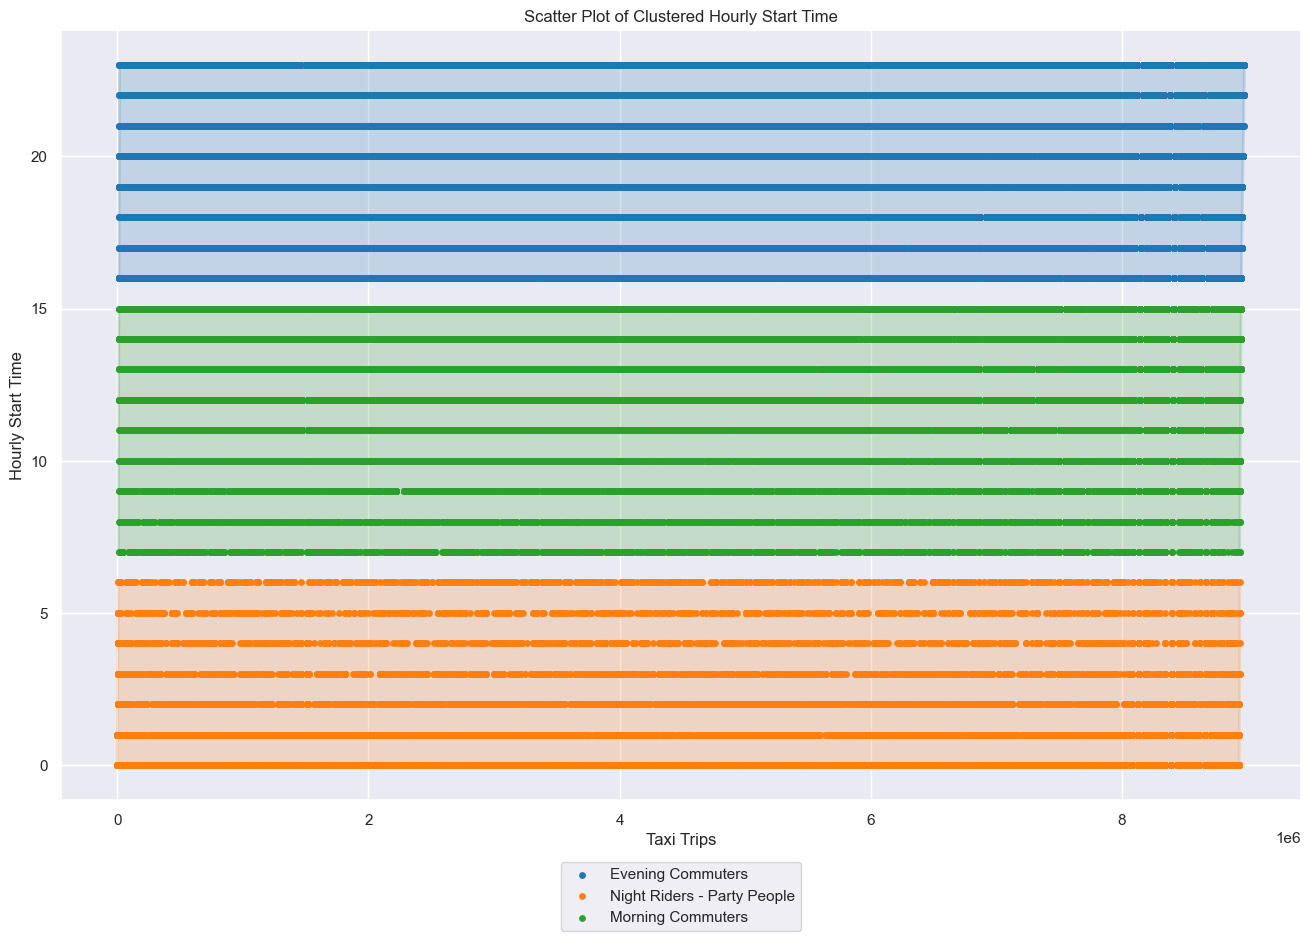

In [26]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_start_time_index.sample(n=100000), x_col='Trip_Index', y_col='start_time_hourly', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Hourly Start Time", plot_title='Scatter Plot of Clustered Hourly Start Time', leg_loc='lower center', anchor=(0.5, -0.18))

<hr style="border: 1px solid #8888;">

## 3.2 Second Cluster Analysis: `Trip_Seconds`

In [27]:
# Feature selection
dfChicago_clu_trip_seconds = dfChicago[['Trip_Seconds']]
dfChicago_clu_trip_seconds

,Trip_Seconds
0,900.0
1,240.0
2,1920.0
3,180.0
4,240.0
...,...
8974515,540.0
8974516,1860.0
8974517,720.0
8974518,660.0


#### Scaling the Data

In [28]:
# Scaling the data
dfChicago_clu_trip_seconds_scaled = scaling_data(dfChicago_clu_trip_seconds)

### 3.2.1 Validation of Number of Clusters

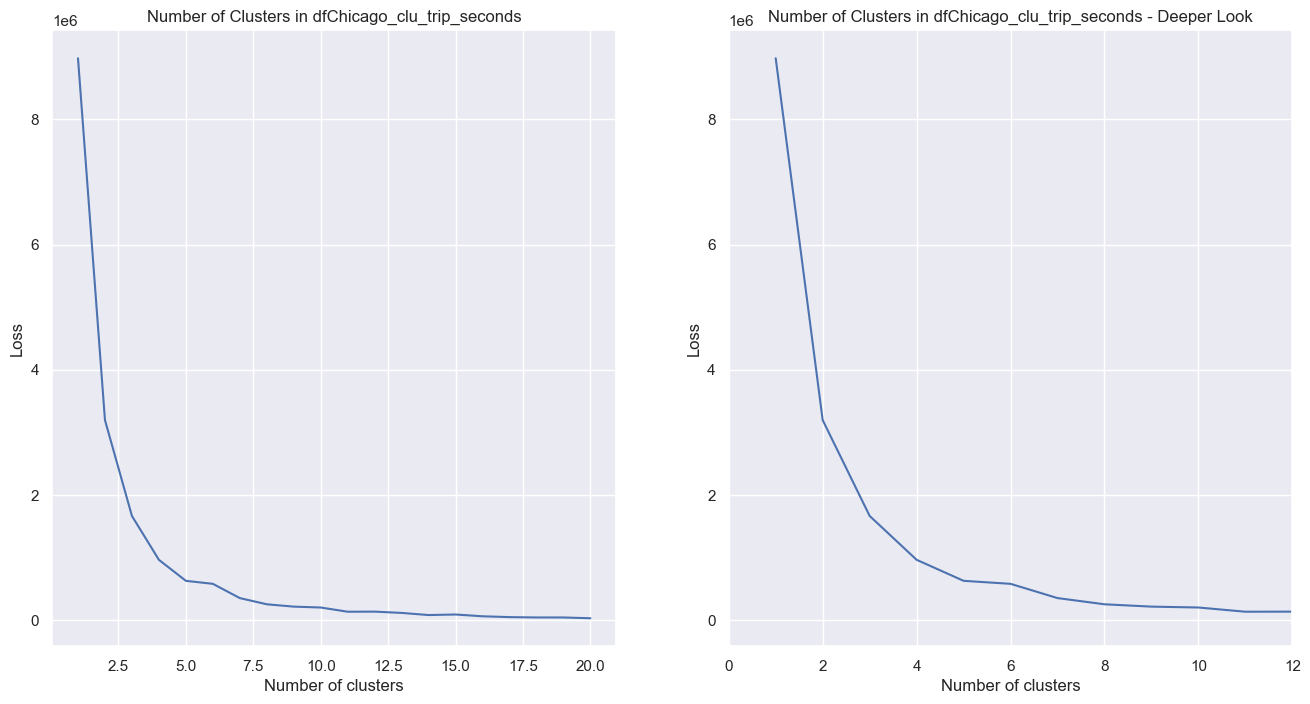

In [29]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_seconds_scaled, "in dfChicago_clu_trip_seconds")

### 3.2.2 Computing Clusters with k-means++

In [30]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_seconds_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [31]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_seconds_scaled)

In [32]:
# creating a column for the calculated clusters

dfChicago_clu_trip_seconds.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_seconds

C:\Users\jonas\AppData\Local\Temp\ipykernel_10584\3771237839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_seconds.loc[:, 'cluster_number'] = Clusters


,Trip_Seconds,cluster_number
0,900.0,0
1,240.0,1
2,1920.0,2
3,180.0,1
4,240.0,1
...,...,...
8974515,540.0,1
8974516,1860.0,2
8974517,720.0,0
8974518,660.0,0


### 3.2.3 Analyzing & Labeling Clusters

In [33]:
dfChicago_clu_trip_seconds[dfChicago_clu_trip_seconds['cluster_number']==0]['cluster_number'].count()

3015335

C:\Users\jonas\AppData\Local\Temp\ipykernel_10584\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


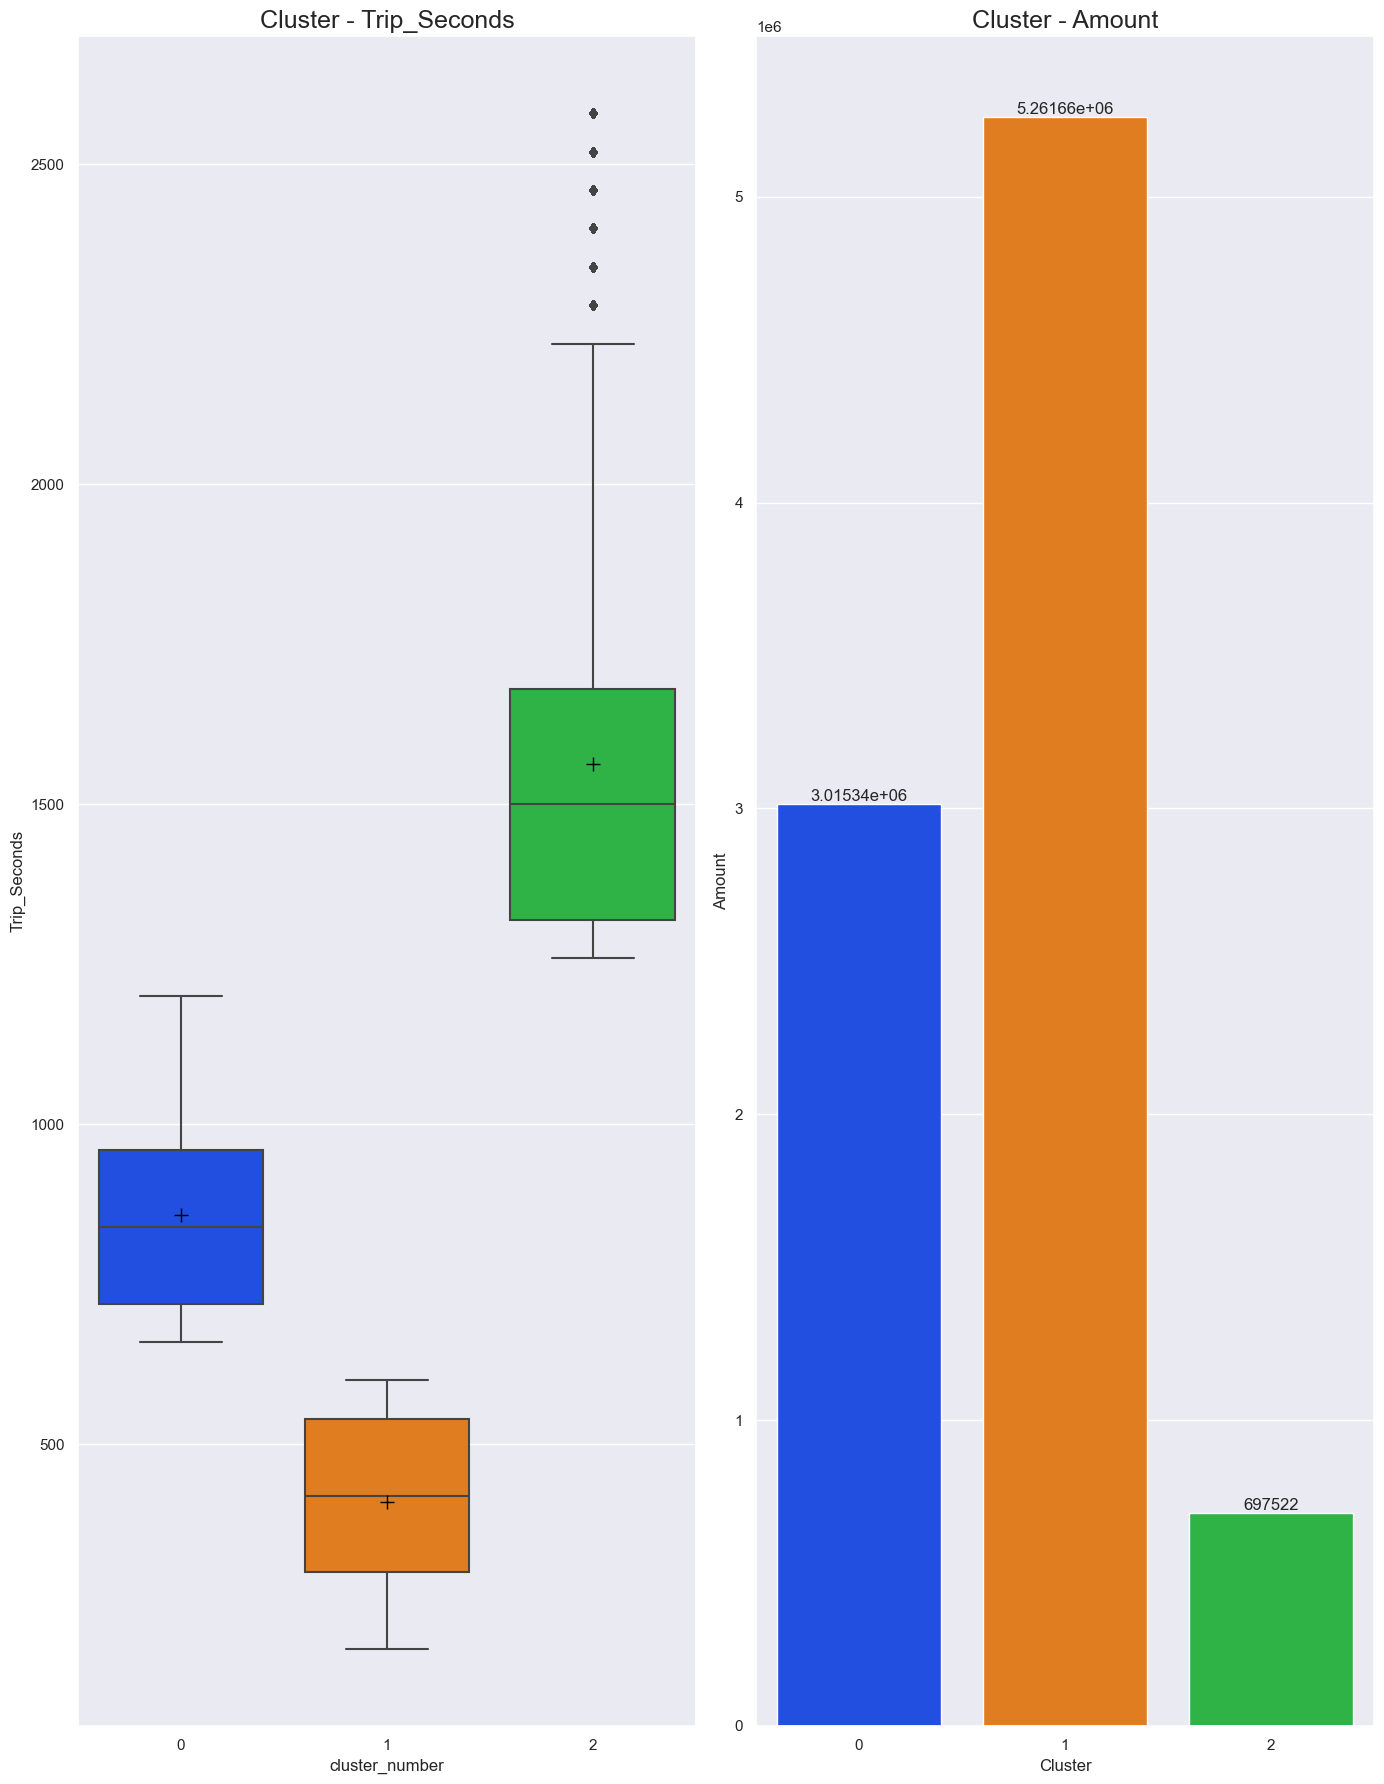

In [34]:
plot_information_about_clusters(dfChicago_clu_trip_seconds, ['Trip_Seconds'], 'cluster_number')

In [35]:
dfChicago_clu_trip_seconds_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_seconds, 3, 'cluster_number')
dfChicago_clu_trip_seconds_quantiles.sort_values(by=['Trip_Seconds'], ascending=False)


,Trip_Seconds,Amount Trips in Cluster,Percentage
Cluster,,,
0,720.0 - 960.0,3015335.0,33.60
1,300.0 - 540.0,5261663.0,58.63
2,1320.0 - 1680.0,697522.0,7.77


In [36]:
label_names = {'0': "Short Trips", 
               '1': "Medium Trips",
               '2': "Long Trips"
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_seconds['Cluster_Label'] = dfChicago_clu_trip_seconds['cluster_number'].astype(str)
dfChicago_clu_trip_seconds = dfChicago_clu_trip_seconds.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_10584\662244246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_seconds['Cluster_Label'] = dfChicago_clu_trip_seconds['cluster_number'].astype(str)


In [37]:
dfChicago_clu_trip_seconds_index = dfChicago_clu_trip_seconds
dfChicago_clu_trip_seconds_index['Trip_Index'] = dfChicago_clu_trip_seconds_index.index
dfChicago_clu_trip_seconds_index

,Trip_Seconds,cluster_number,Cluster_Label,Trip_Index
0,900.0,0,Short Trips,0
1,240.0,1,Medium Trips,1
2,1920.0,2,Long Trips,2
3,180.0,1,Medium Trips,3
4,240.0,1,Medium Trips,4
...,...,...,...,...
8974515,540.0,1,Medium Trips,8974515
8974516,1860.0,2,Long Trips,8974516
8974517,720.0,0,Short Trips,8974517
8974518,660.0,0,Short Trips,8974518


### 3.2.4 Plotting the Clustering Results

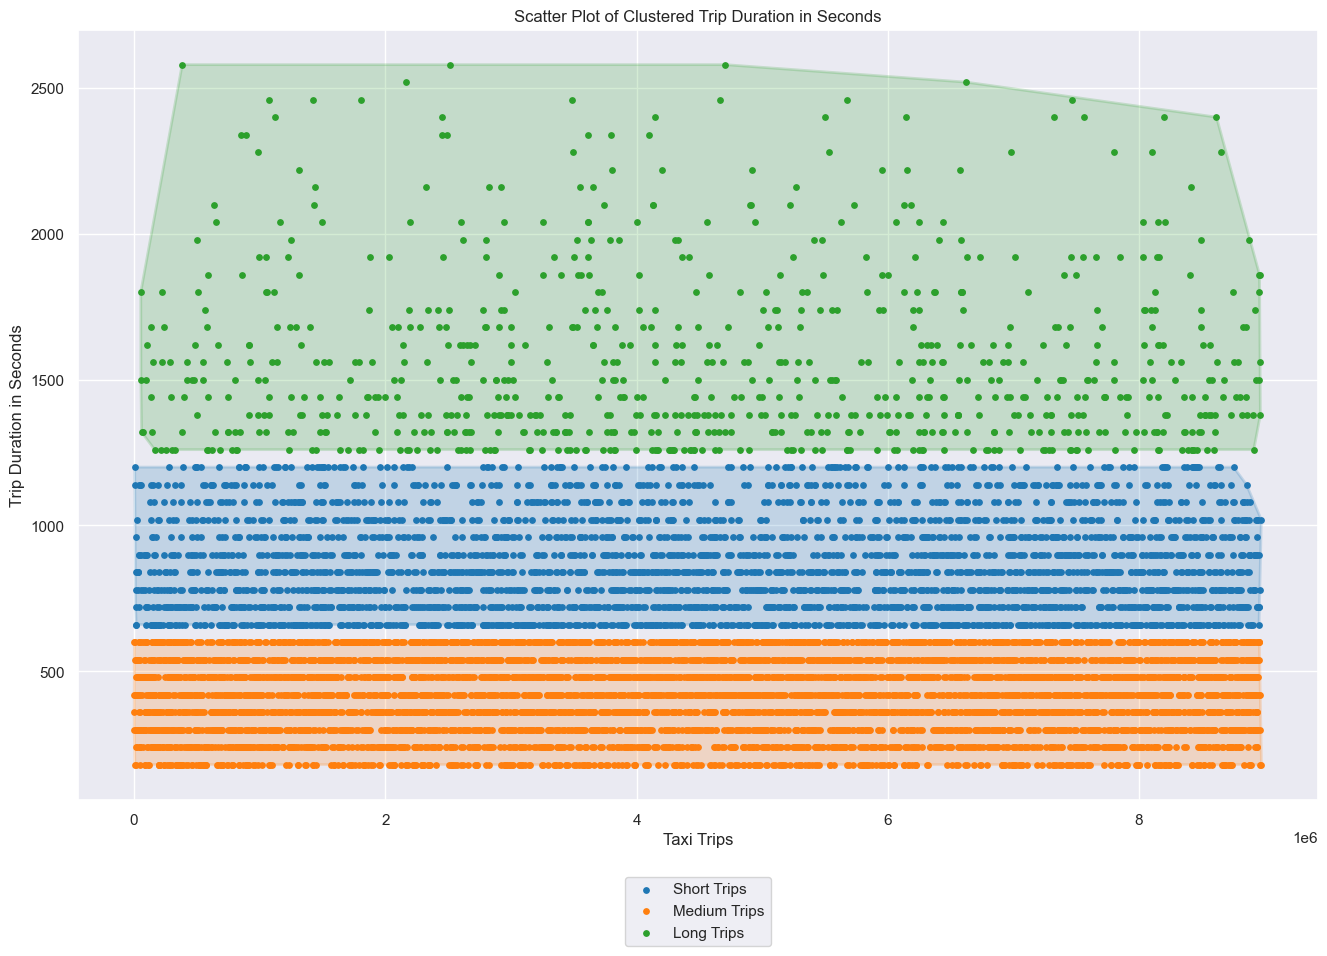

In [38]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_seconds_index.sample(n=10000), x_col='Trip_Index', y_col='Trip_Seconds', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Duration in Seconds", plot_title='Scatter Plot of Clustered Trip Duration in Seconds', leg_loc='lower center', anchor=(0.5, -0.2))

<hr style="border: 1px solid #8888;">

## 3.3 Third Cluster Analysis: `Trip_Miles`

In [39]:
# Feature selection
dfChicago_clu_trip_miles = dfChicago[['Trip_Miles']]
dfChicago_clu_trip_miles

,Trip_Miles
0,2.7
1,0.4
2,0.6
3,1.0
4,0.3
...,...
8974515,1.4
8974516,5.9
8974517,2.0
8974518,3.5


#### Scaling the Data

In [40]:
# Scaling the data
dfChicago_clu_trip_miles_scaled = scaling_data(dfChicago_clu_trip_miles)

### 3.3.1 Validation of Number of Clusters

KeyboardInterrupt: 

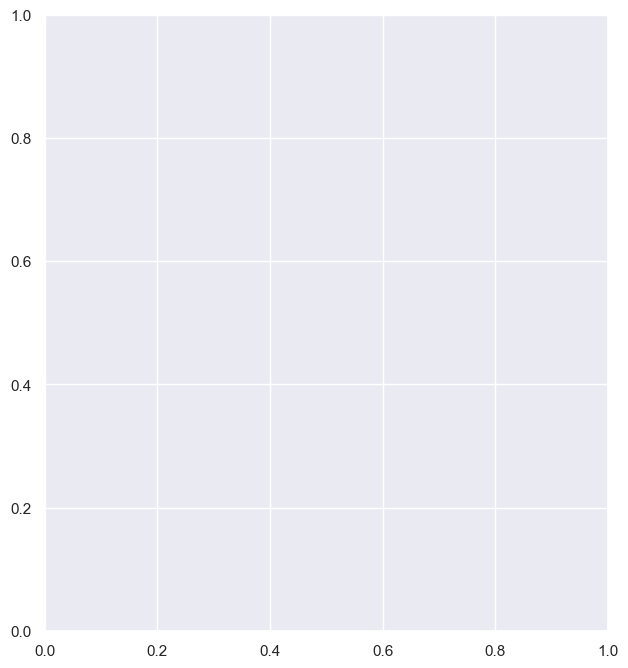

In [41]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_miles_scaled, "in dfChicago_clu_trip_miles")

### 3.3.2 Computing Clusters with k-means++

In [ ]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_miles_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_miles_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# creating a column for the calculated clusters

dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_miles

C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\3326964530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters


,Trip_Miles,cluster_number
0,2.7,0
1,0.4,1
2,0.6,1
3,1.0,1
4,0.3,1
...,...,...
8974515,1.4,1
8974516,5.9,0
8974517,2.0,1
8974518,3.5,0


### 3.3.3 Analyzing & Labeling Clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


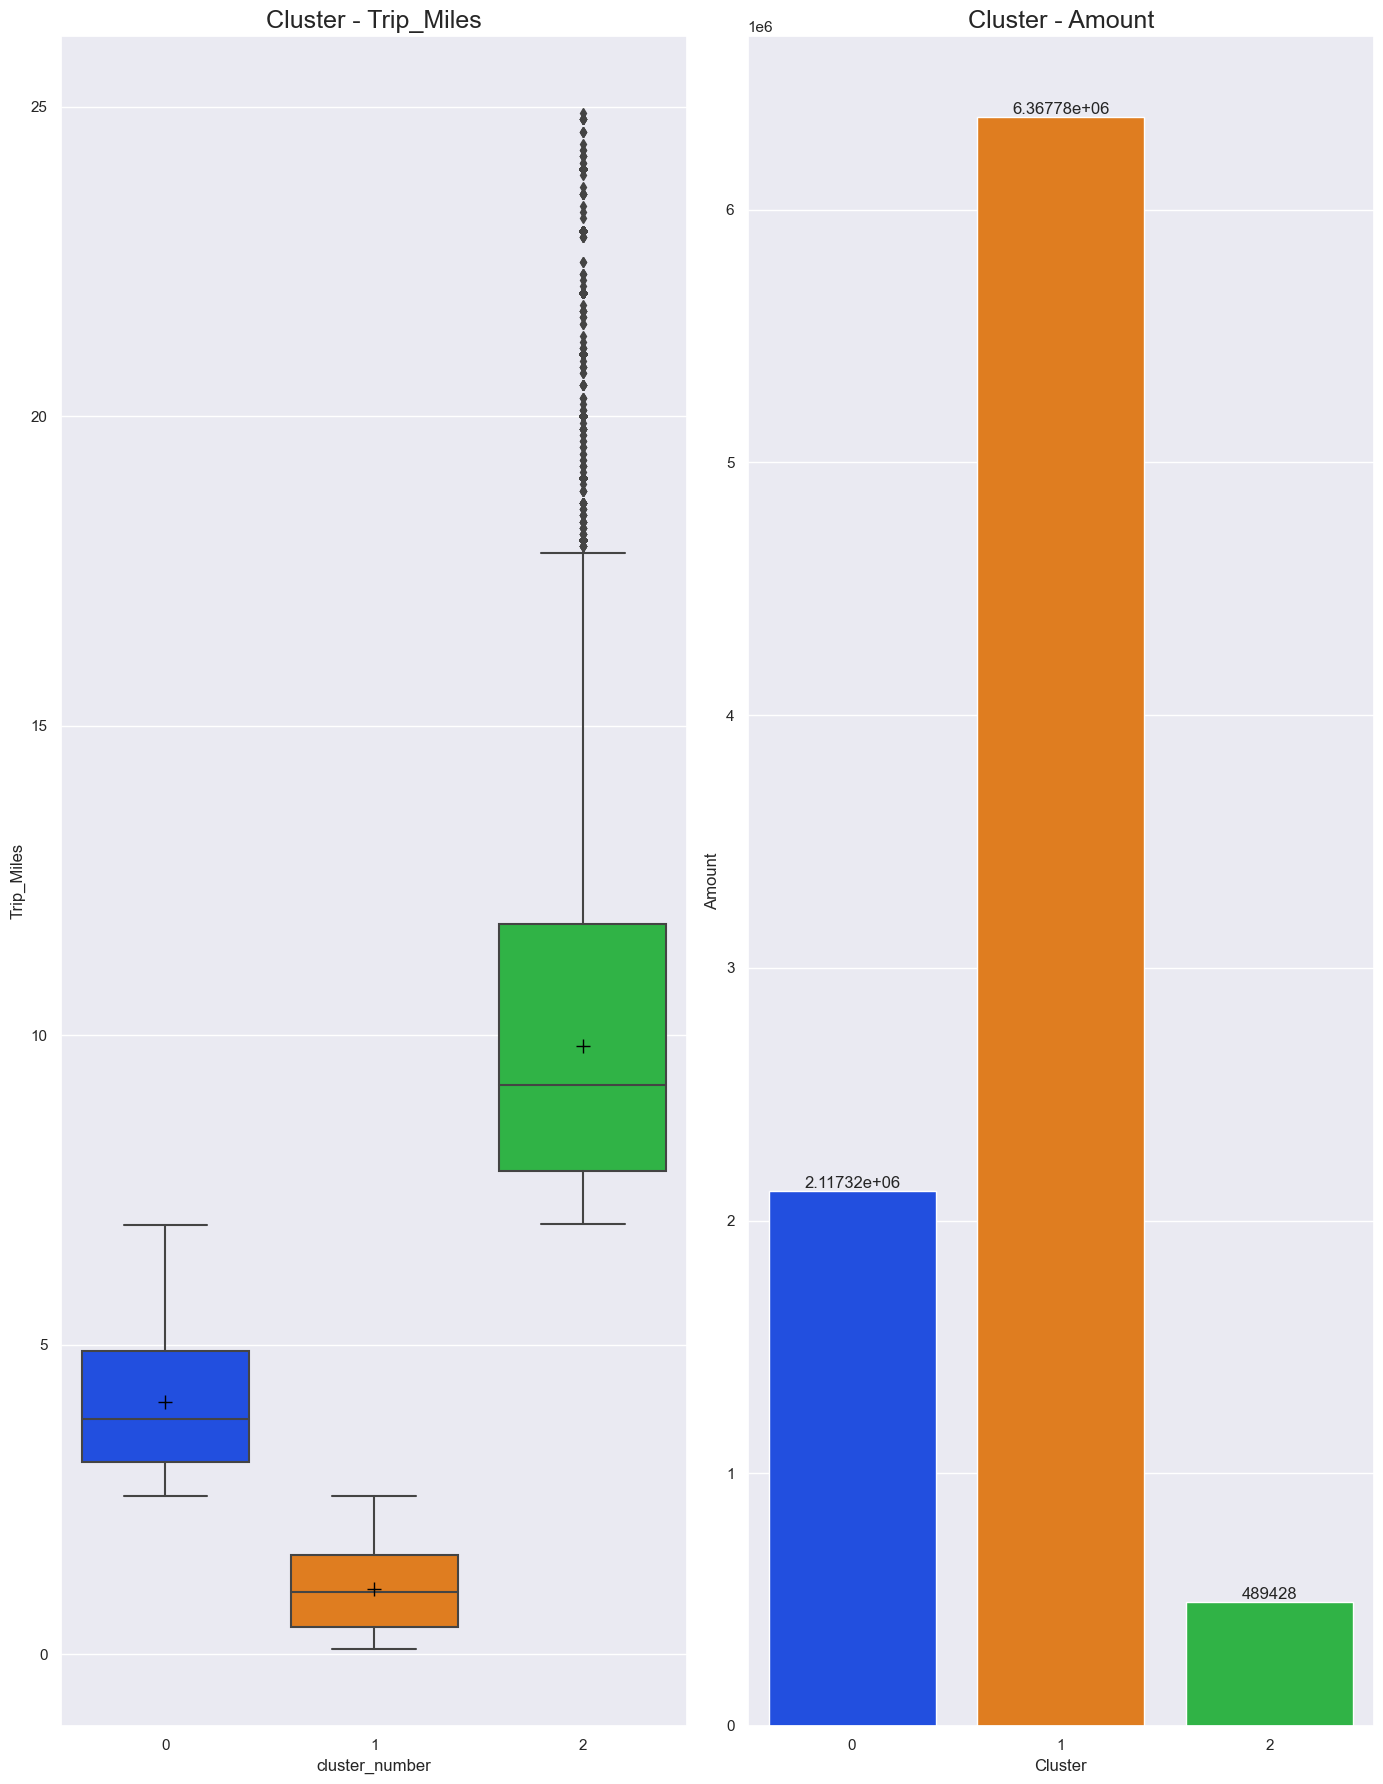

In [ ]:
plot_information_about_clusters(dfChicago_clu_trip_miles, ['Trip_Miles'], 'cluster_number')

In [ ]:
dfChicago_clu_trip_miles_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_miles, 3, 'cluster_number')
dfChicago_clu_trip_miles_quantiles.sort_values(by=['Trip_Miles'], ascending=False)

,Trip_Miles,Amount Trips in Cluster,Percentage
Cluster,,,
2,7.8 - 11.8,489428.0,5.45
0,3.1 - 4.9,2117317.0,23.59
1,0.44 - 1.6,6367775.0,70.95


In [ ]:
label_names = {'0': "Short Trips", 
               '1': "Medium Trips",
               '2': "Long Trips"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)
dfChicago_clu_trip_miles = dfChicago_clu_trip_miles.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\2306004952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)


In [ ]:
dfChicago_clu_trip_miles_index = dfChicago_clu_trip_miles
dfChicago_clu_trip_miles_index['Trip_Index'] = dfChicago_clu_trip_miles_index.index
dfChicago_clu_trip_miles_index

,Trip_Miles,cluster_number,Cluster_Label,Trip_Index
0,2.7,0,Short Trips,0
1,0.4,1,Medium Trips,1
2,0.6,1,Medium Trips,2
3,1.0,1,Medium Trips,3
4,0.3,1,Medium Trips,4
...,...,...,...,...
8974515,1.4,1,Medium Trips,8974515
8974516,5.9,0,Short Trips,8974516
8974517,2.0,1,Medium Trips,8974517
8974518,3.5,0,Short Trips,8974518


### 3.3.4 Plotting the Clustering Results

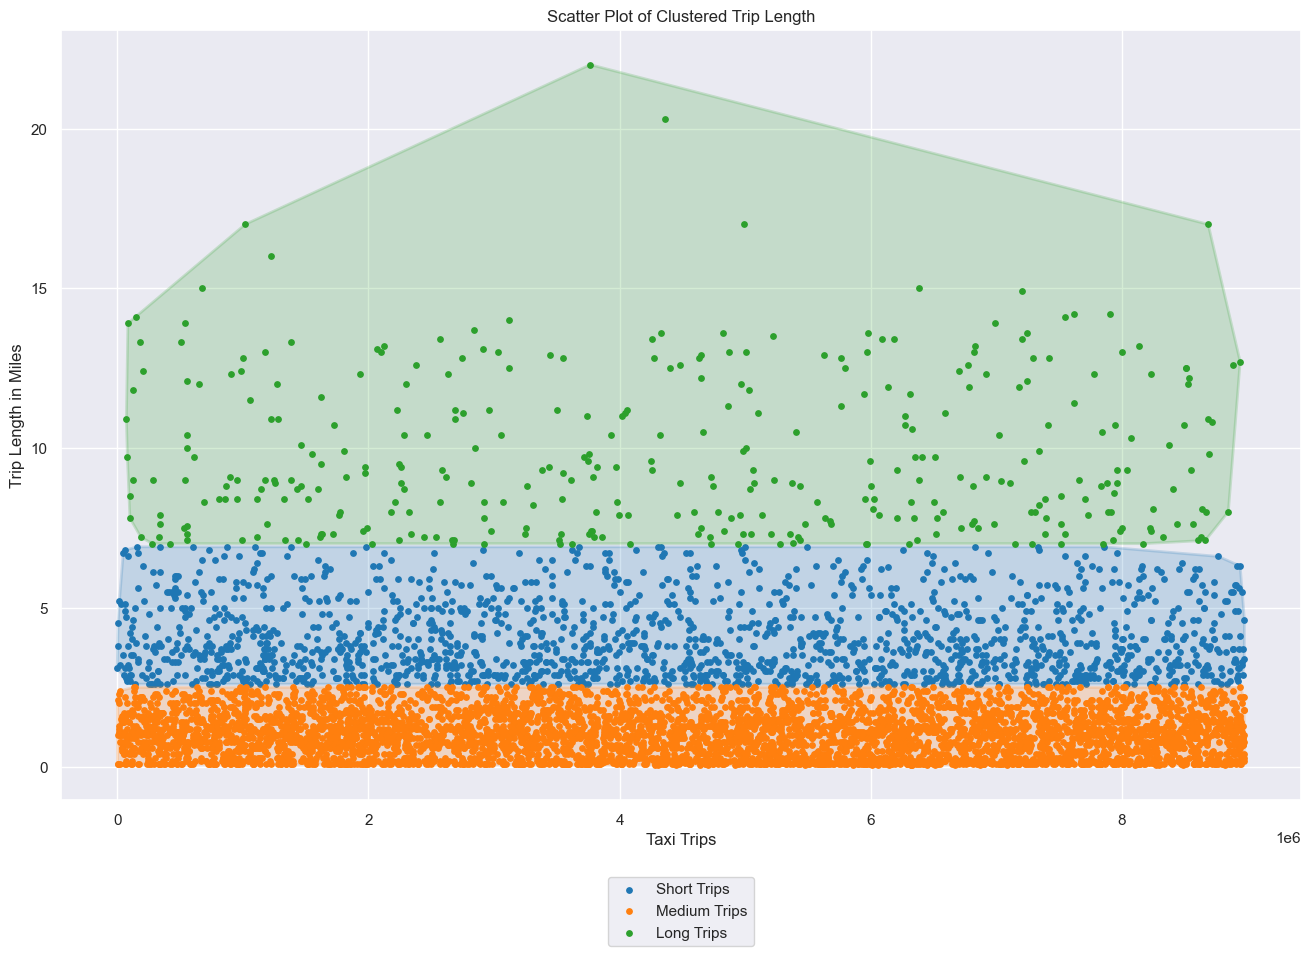

In [ ]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_miles_index.sample(n=7000), x_col='Trip_Index', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Length in Miles", plot_title='Scatter Plot of Clustered Trip Length', leg_loc='lower center', anchor=(0.5, -0.2))

<hr style="border: 1px solid #8888;">

## 3.4 Fourth Cluster Analysis: `start_time_hourly`, `Trip_Seconds`, `Trip_Miles`

In [ ]:
# Feature selection
dfChicago_clu_combined = dfChicago[['start_time_hourly', 'Trip_Seconds' ,'Trip_Miles']]
dfChicago_clu_combined

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
2,0,1920.0,0.6
3,0,180.0,1.0
4,0,240.0,0.3
...,...,...,...
8974515,23,540.0,1.4
8974516,23,1860.0,5.9
8974517,23,720.0,2.0
8974518,23,660.0,3.5


#### Scaling the Data

In [ ]:
# Scaling the data
dfChicago_clu_combined_scaled = scaling_data(dfChicago_clu_combined)

### 3.4.1 Validation of Number of Clusters

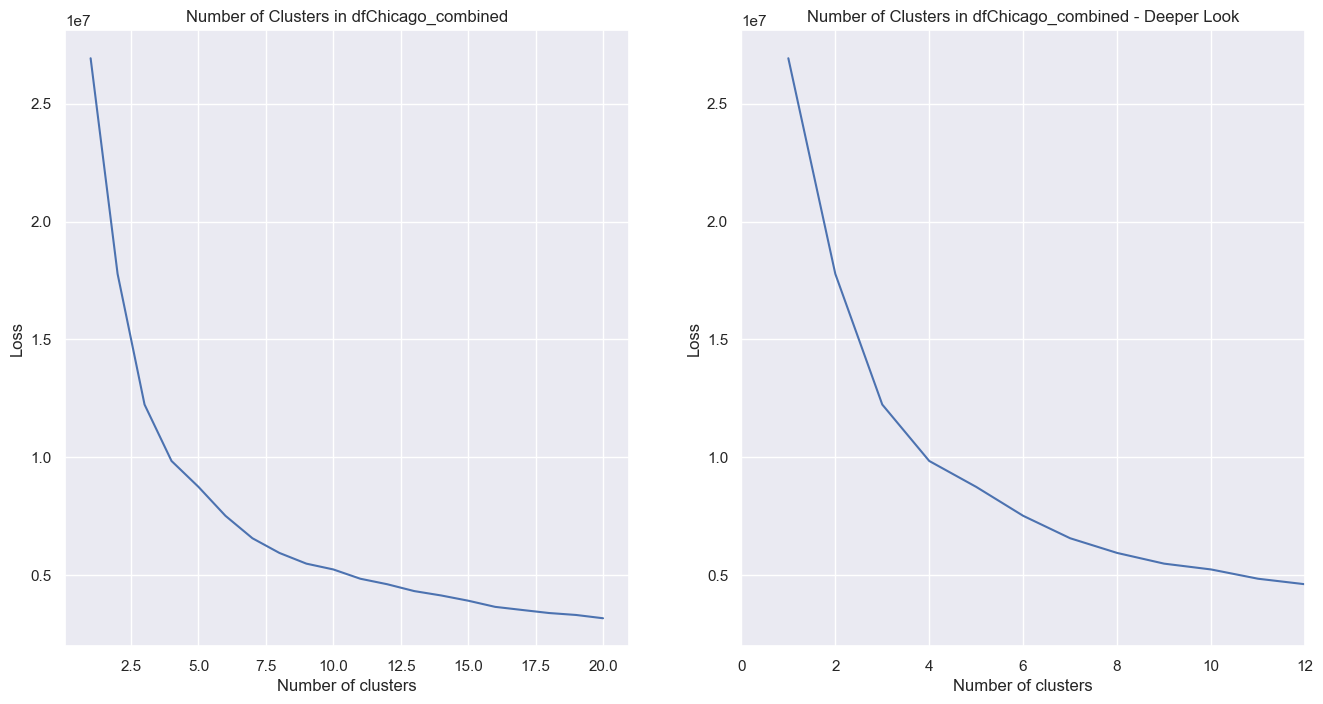

In [ ]:
plot_best_fitting_number_of_clusters(dfChicago_clu_combined_scaled, "in dfChicago_combined")

### 3.4.2 Computing Clusters with k-means++

In [ ]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=4,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_combined_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_combined_scaled)

# creating a column for the calculated clusters

dfChicago_clu_combined.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_combined

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\1325623314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_combined.loc[:, 'cluster_number'] = Clusters


,start_time_hourly,Trip_Seconds,Trip_Miles,cluster_number
0,0,900.0,2.7,0
1,0,240.0,0.4,0
2,0,1920.0,0.6,3
3,0,180.0,1.0,0
4,0,240.0,0.3,0
...,...,...,...,...
8974515,23,540.0,1.4,1
8974516,23,1860.0,5.9,2
8974517,23,720.0,2.0,1
8974518,23,660.0,3.5,3


### 3.4.3 Analyzing & Labeling Clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


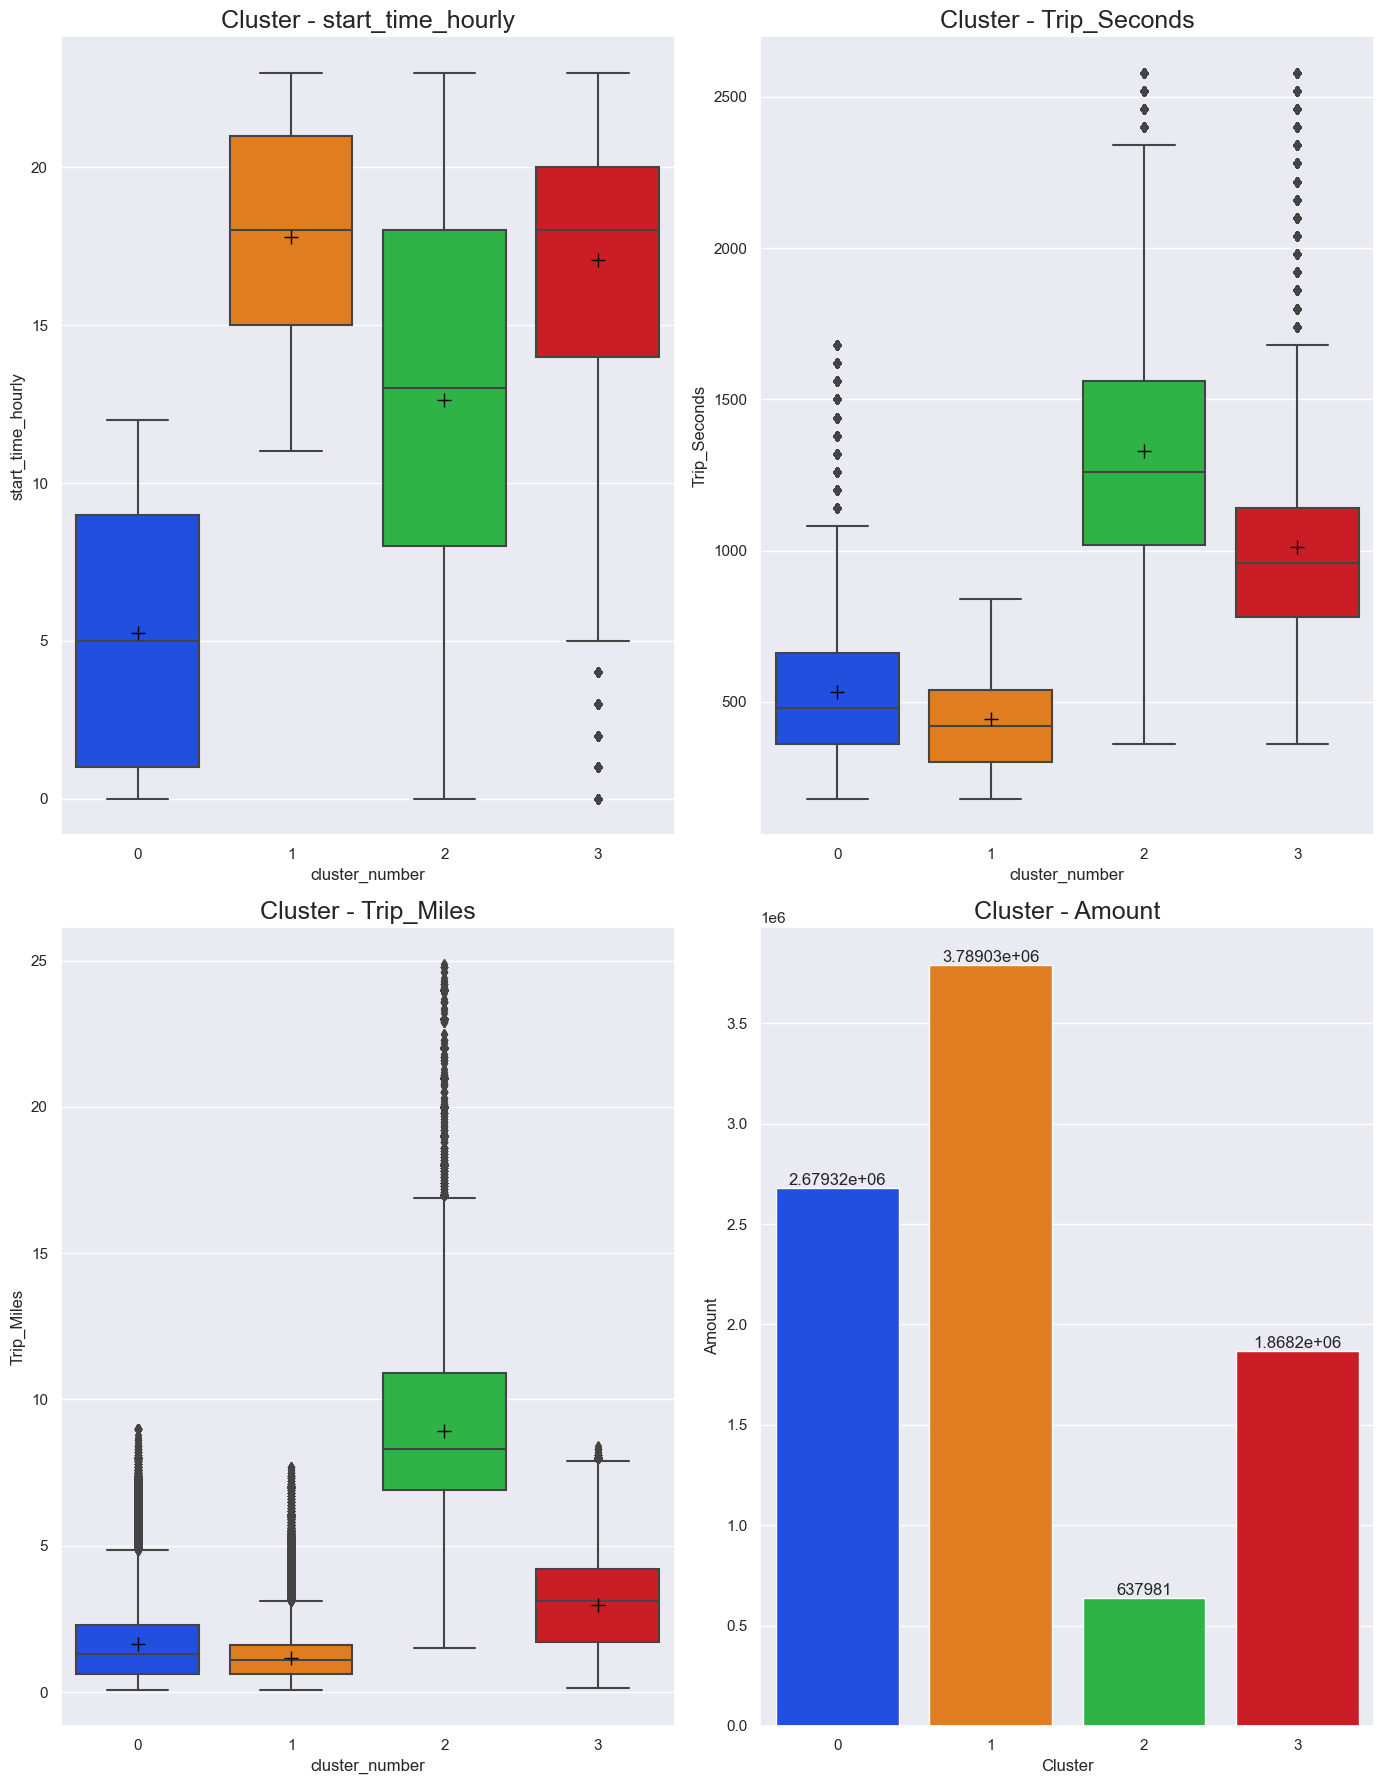

In [ ]:
plot_information_about_clusters(dfChicago_clu_combined, ['start_time_hourly', 'Trip_Seconds' ,'Trip_Miles'], 'cluster_number')

In [ ]:
dfChicago_clu_combined_quantiles = get_quantiles_of_clusters(dfChicago_clu_combined, 4, 'cluster_number')
dfChicago_clu_combined_quantiles.sort_values(by=['start_time_hourly', 'Trip_Seconds'], ascending=False)

,start_time_hourly,Trip_Seconds,Trip_Miles,Amount Trips in Cluster,Percentage
Cluster,,,,,
2,8.0 - 18.0,1020.0 - 1560.0,6.9 - 10.9,637981.0,7.11
1,15.0 - 21.0,300.0 - 540.0,0.6 - 1.6,3789027.0,42.22
3,14.0 - 20.0,780.0 - 1140.0,1.7 - 4.2,1868196.0,20.82
0,1.0 - 9.0,360.0 - 660.0,0.6 - 2.3,2679316.0,29.85


In [ ]:
label_names = {'0': "Evening Commuters", 
               '1': "Short to Medium Rides (2 - 4 Miles)",
               '2': "Long Rides (7 - 11 miles)",
               '3': "Party People / Night Riders",
               '4': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_combined['Cluster_Label'] = dfChicago_clu_combined['cluster_number'].astype(str)
dfChicago_clu_combined = dfChicago_clu_combined.replace({"Cluster_Label": label_names})

#dfChicago_clu_combined_index = dfChicago_clu_combined
#dfChicago_clu_combined_index['Trip_Index'] = dfChicago_clu_combined_index.index
#dfChicago_clu_combined_index

C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\626434873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_combined['Cluster_Label'] = dfChicago_clu_combined['cluster_number'].astype(str)


### 3.4.4 Plotting the Clustering Results

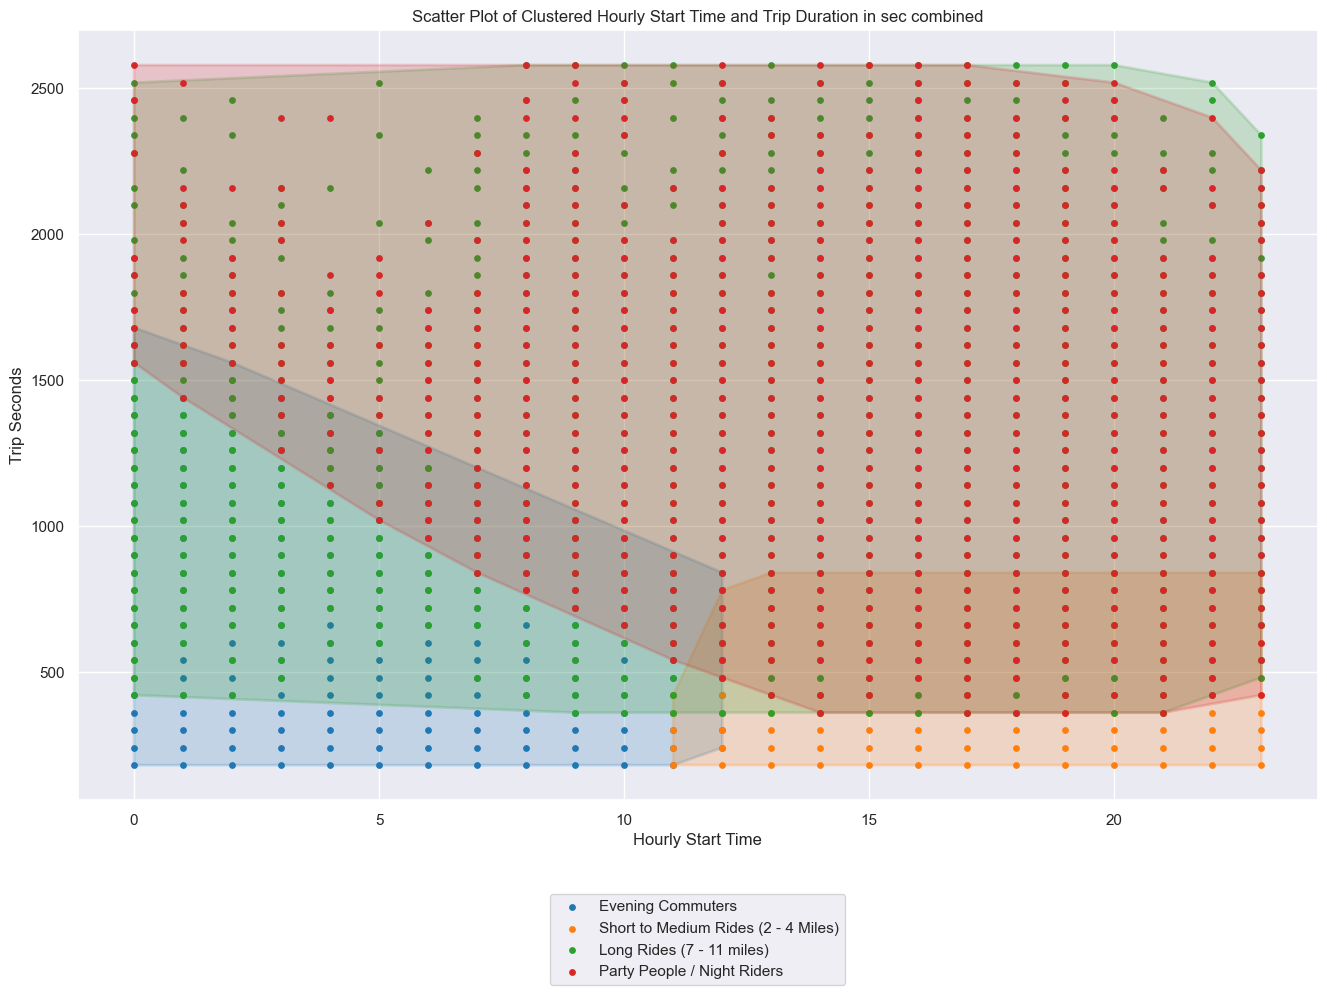

In [ ]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=100_000), x_col='start_time_hourly', y_col='Trip_Seconds', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Seconds", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in sec combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

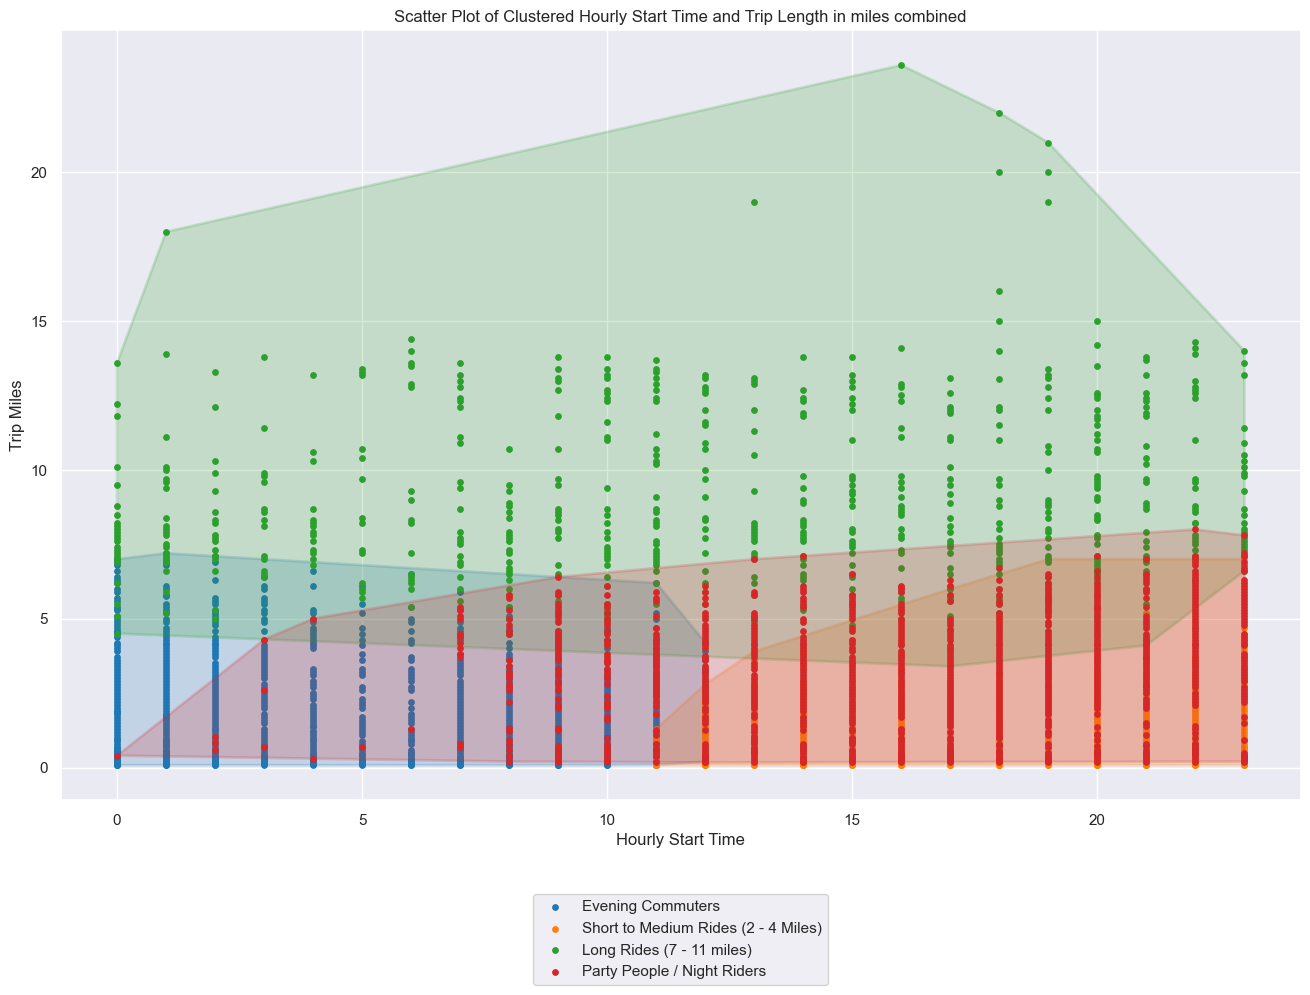

In [ ]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=10_000), x_col='start_time_hourly', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Length in miles combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

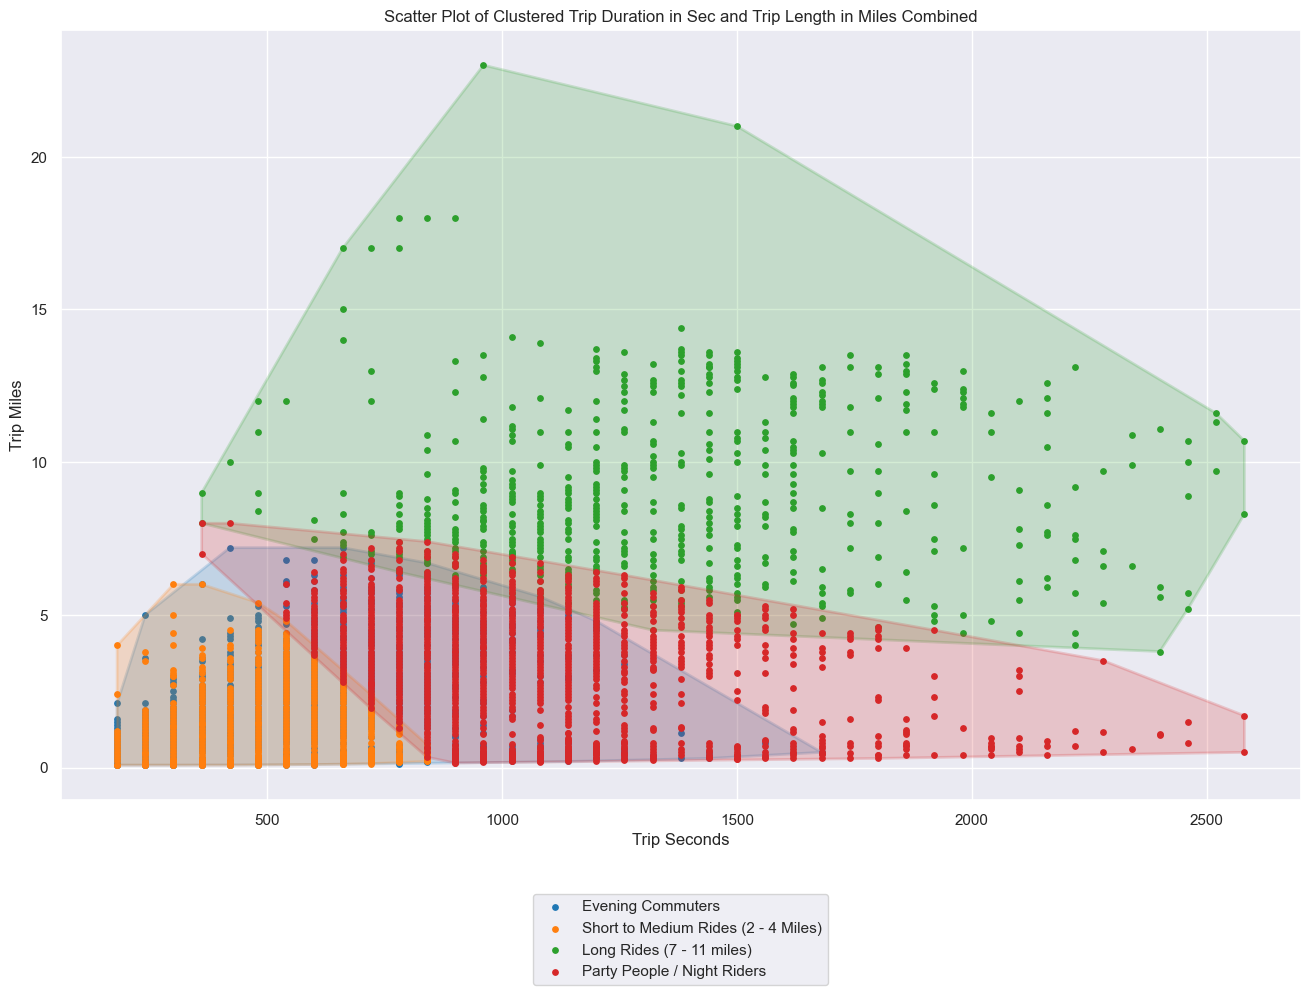

In [ ]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=10_000), x_col='Trip_Seconds', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Seconds', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Duration in Sec and Trip Length in Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


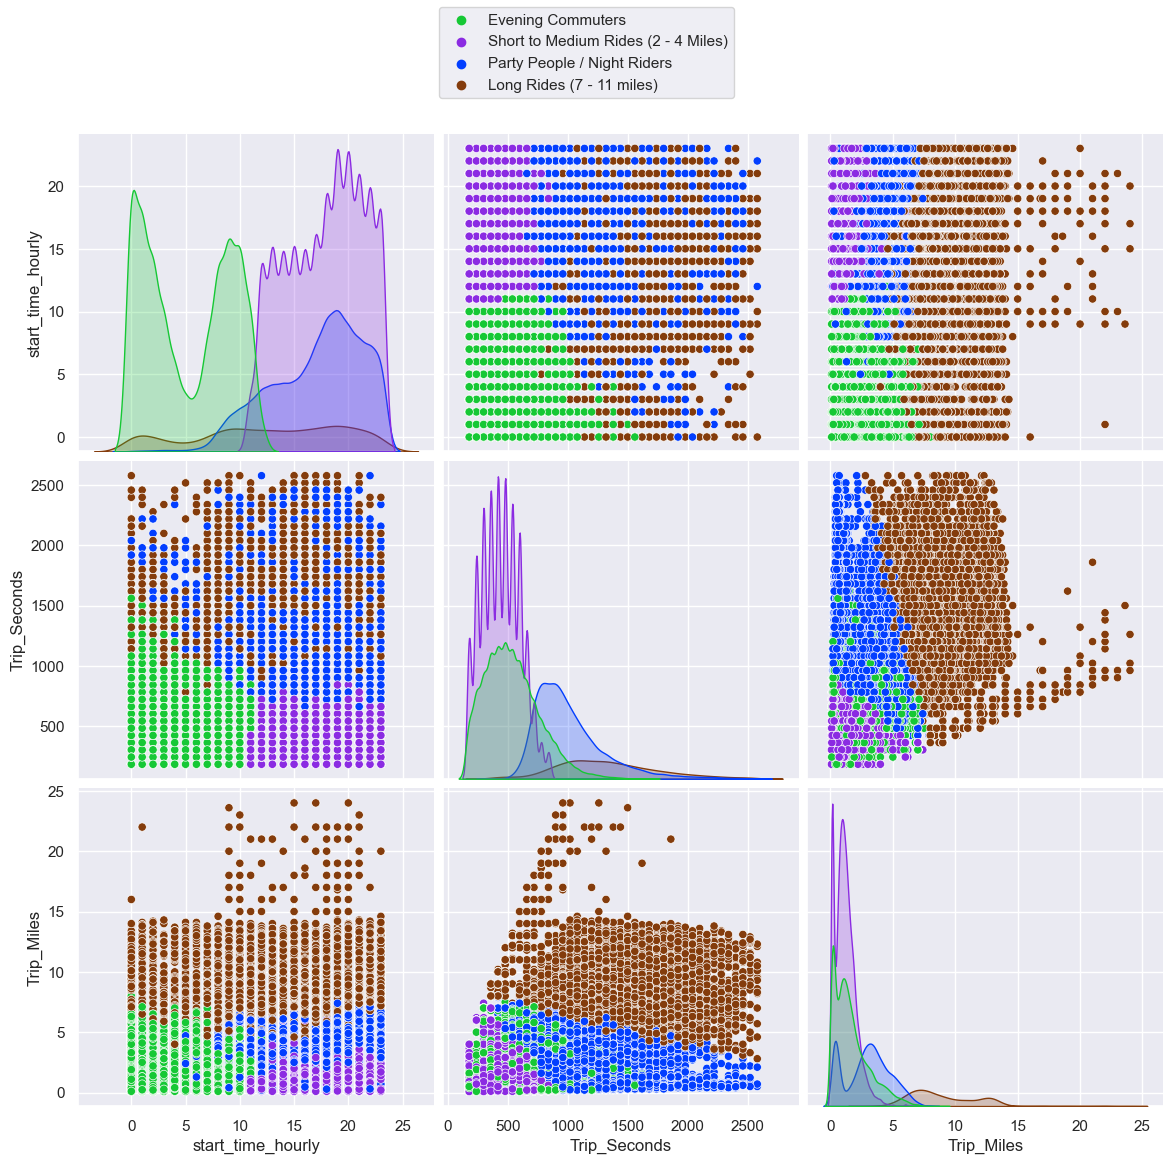

In [ ]:
colors = {'Evening Commuters' : '#16C835',
          'Morning Commuters' : '#FF7C00',
          'Short to Medium Rides (2 - 4 Miles)' : '#8B2BE2',
          'Long Rides (7 - 11 miles)' : '#843C0C',
          'Party People / Night Riders': '#023EFF'}

g = sns.pairplot(data=dfChicago_clu_combined[['start_time_hourly', 'Trip_Seconds' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)

<hr style="border: 1px solid #8888;">

## 3.5 Fifth Cluster Analysis: `distance_to_city_center_pickup`

In [ ]:
# Feature selection
dfChicago_clu_distance_to_city_center_pickup = dfChicago[['distance_to_city_center_pickup']]
dfChicago_clu_distance_to_city_center_pickup

,distance_to_city_center_pickup
0,1.614272
1,3.617721
2,4.476686
3,2.685629
4,0.495382
...,...
8974515,0.893287
8974516,1.401331
8974517,0.725199
8974518,1.344327


#### Scaling the Data

In [ ]:
# Scaling the data
dfChicago_clu_distance_to_city_center_pickup_scaled = scaling_data(dfChicago_clu_distance_to_city_center_pickup)

### 3.5.1 Validation of Number of Clusters

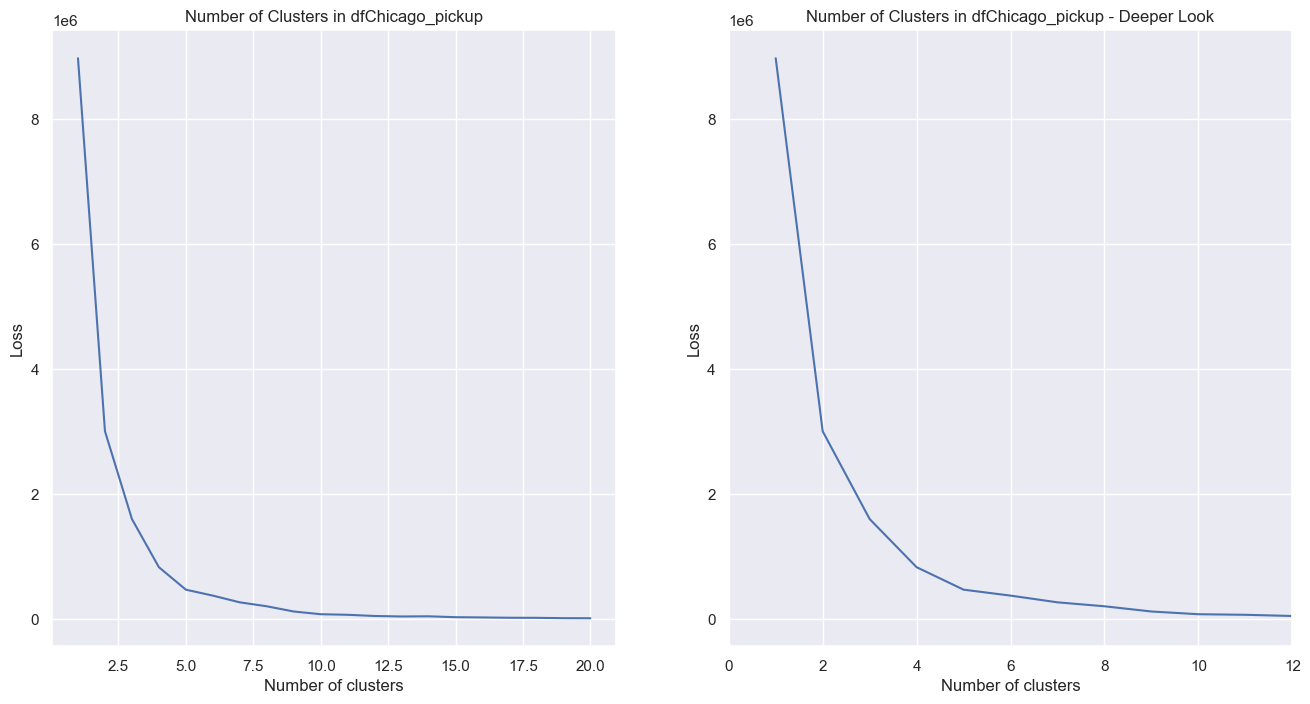

In [ ]:
plot_best_fitting_number_of_clusters(dfChicago_clu_distance_to_city_center_pickup_scaled, "in dfChicago_pickup")

### 3.5.2 Computing Clusters with k-means++

In [ ]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_distance_to_city_center_pickup_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_distance_to_city_center_pickup_scaled)

# creating a column for the calculated clusters

dfChicago_clu_distance_to_city_center_pickup.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_distance_to_city_center_pickup

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\275767884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_pickup.loc[:, 'cluster_number'] = Clusters


,distance_to_city_center_pickup,cluster_number
0,1.614272,0
1,3.617721,1
2,4.476686,1
3,2.685629,1
4,0.495382,0
...,...,...
8974515,0.893287,0
8974516,1.401331,0
8974517,0.725199,0
8974518,1.344327,0


### 3.5.3 Analyzing & Labeling Clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


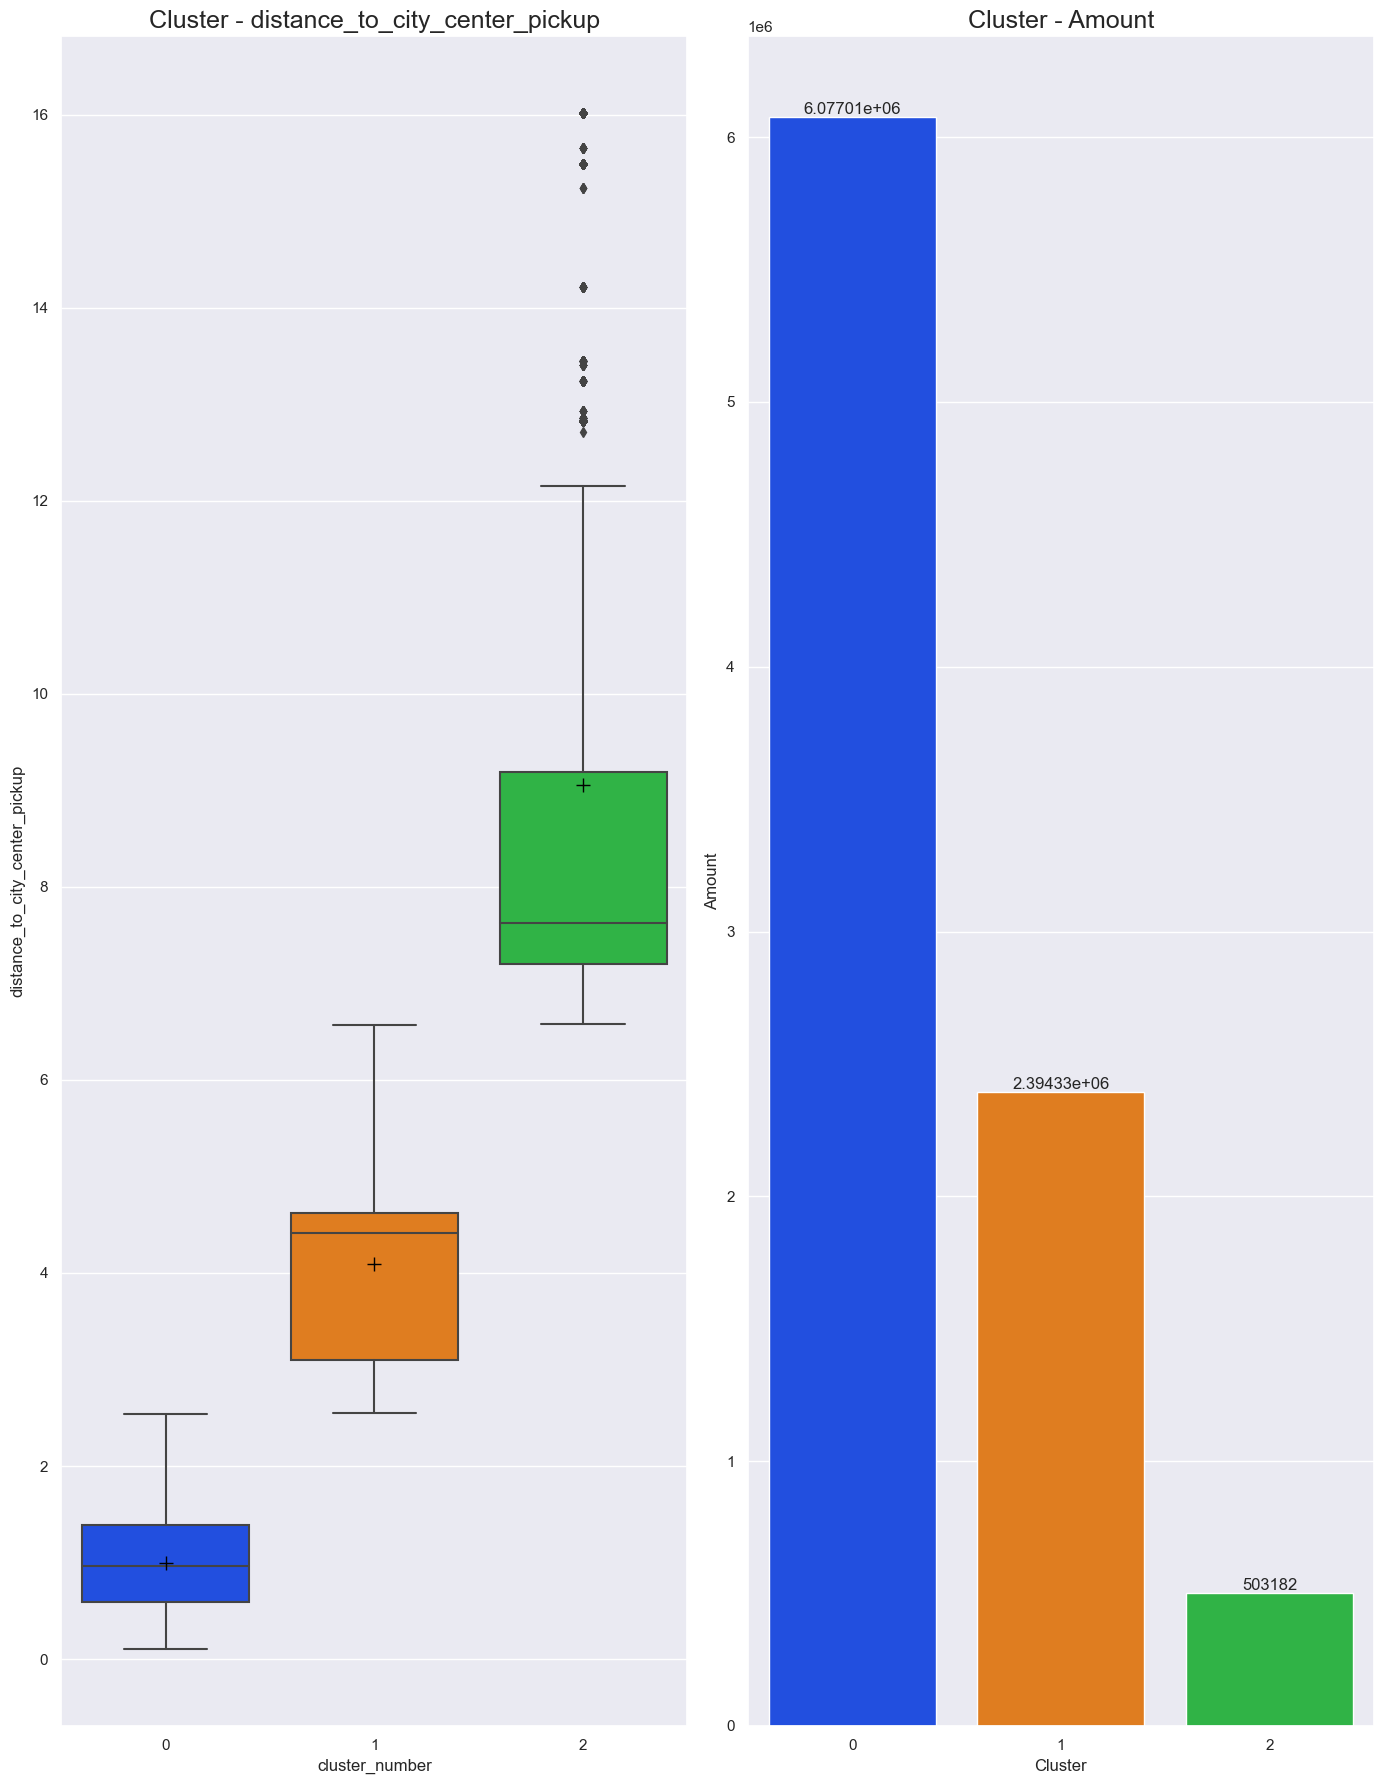

In [ ]:
plot_information_about_clusters(dfChicago_clu_distance_to_city_center_pickup, ['distance_to_city_center_pickup'], 'cluster_number')

In [ ]:
dfChicago_clu_distance_to_city_center_pickup_quantiles = get_quantiles_of_clusters(dfChicago_clu_distance_to_city_center_pickup, 3, 'cluster_number')
dfChicago_clu_distance_to_city_center_pickup_quantiles.sort_values(by=['distance_to_city_center_pickup'], ascending=False)

,distance_to_city_center_pickup,Amount Trips in Cluster,Percentage
Cluster,,,
2,7.2 - 9.19,503182.0,5.61
1,3.1 - 4.62,2394327.0,26.68
0,0.59 - 1.39,6077011.0,67.71


In [ ]:
label_names = {'0': "Close to City Center", 
               '1': "Medium Distance from the City Center",
               '2': "Far from City Center "
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_distance_to_city_center_pickup['Cluster_Label'] = dfChicago_clu_distance_to_city_center_pickup['cluster_number'].astype(str)
dfChicago_clu_distance_to_city_center_pickup = dfChicago_clu_distance_to_city_center_pickup.replace({"Cluster_Label": label_names})

dfChicago_clu_distance_to_city_center_pickup_index = dfChicago_clu_distance_to_city_center_pickup
dfChicago_clu_distance_to_city_center_pickup_index['Trip_Index'] = dfChicago_clu_distance_to_city_center_pickup_index.index
dfChicago_clu_distance_to_city_center_pickup_index

C:\Users\jonas\AppData\Local\Temp\ipykernel_16156\3786250274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_pickup['Cluster_Label'] = dfChicago_clu_distance_to_city_center_pickup['cluster_number'].astype(str)


,distance_to_city_center_pickup,cluster_number,Cluster_Label,Trip_Index
0,1.614272,0,Close to City Center,0
1,3.617721,1,Medium Distance from the City Center,1
2,4.476686,1,Medium Distance from the City Center,2
3,2.685629,1,Medium Distance from the City Center,3
4,0.495382,0,Close to City Center,4
...,...,...,...,...
8974515,0.893287,0,Close to City Center,8974515
8974516,1.401331,0,Close to City Center,8974516
8974517,0.725199,0,Close to City Center,8974517
8974518,1.344327,0,Close to City Center,8974518


### 3.5.4 Plotting the Clustering Results

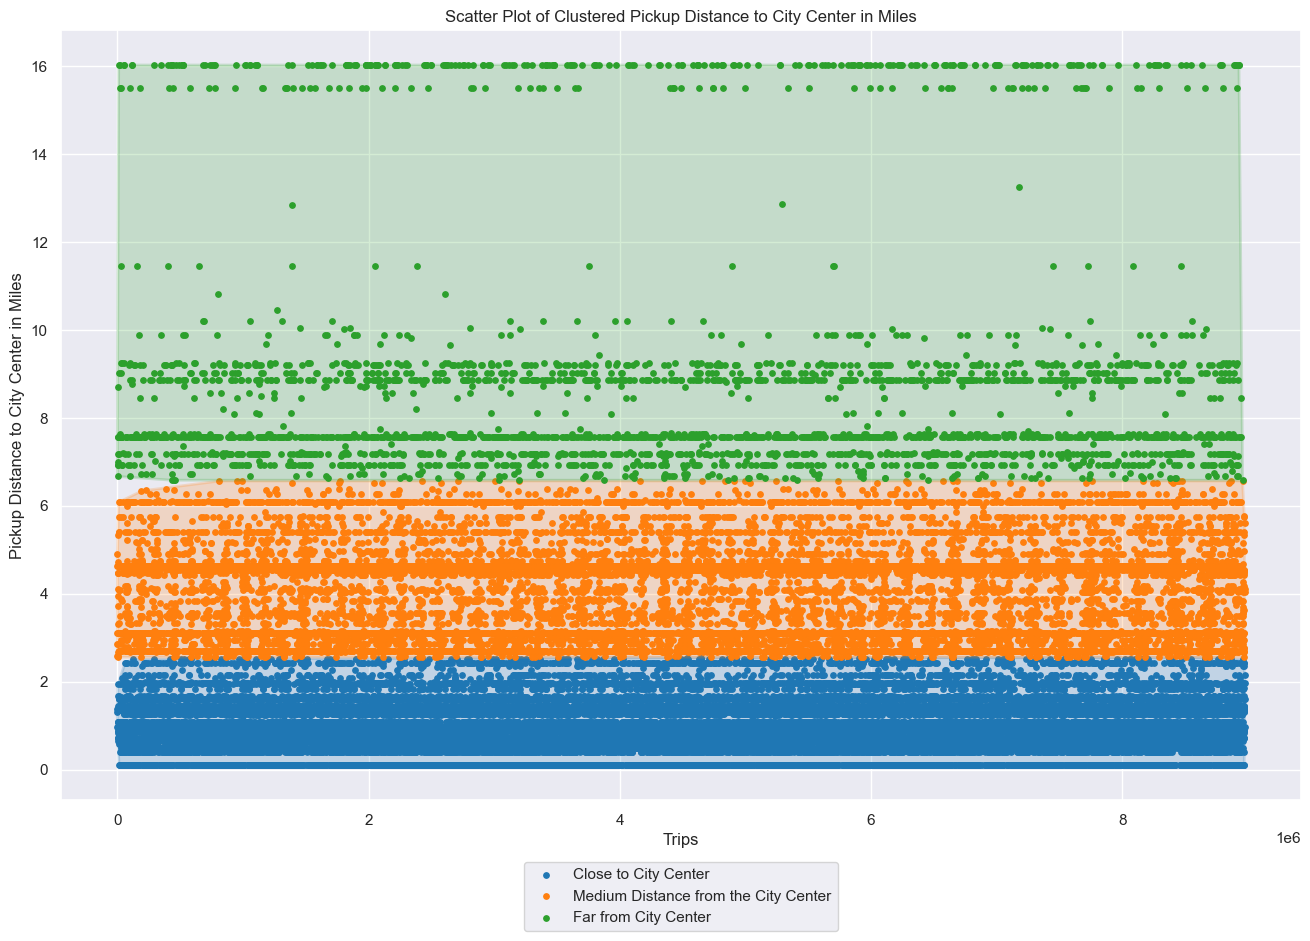

In [ ]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_distance_to_city_center_pickup_index.sample(n=50_000), x_col='Trip_Index', y_col='distance_to_city_center_pickup', cluster_col='cluster_number',
                        label_col="Cluster_Label", size_tuple=(16, 10), dp_size=15, x_label='Trips', y_label="Pickup Distance to City Center in Miles", 
                        plot_title='Scatter Plot of Clustered Pickup Distance to City Center in Miles', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.5.5 Displaying Results on a Map of Chicago

In [ ]:
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.DataFrame(dfChicago_clu_distance_to_city_center_pickup_index)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.concat([dfChicago_clu_distance_to_city_center_pickup_hex_ids, 
                                                                dfChicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_distance_to_city_center_pickup_hex_ids

,distance_to_city_center_pickup,cluster_number,Cluster_Label,Trip_Index,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res
0,1.614272,0,Close to City Center,0,882664ca91fffff,872664ca9ffffff,862664cafffffff
1,3.617721,1,Medium Distance from the City Center,1,882664c12bfffff,872664c12ffffff,862664c17ffffff
2,4.476686,1,Medium Distance from the City Center,2,882664ca11fffff,872664ca1ffffff,862664ca7ffffff
3,2.685629,1,Medium Distance from the City Center,3,882664cac3fffff,872664cacffffff,862664cafffffff
4,0.495382,0,Close to City Center,4,882664c1adfffff,872664c1affffff,862664c1fffffff
...,...,...,...,...,...,...,...
8974515,0.893287,0,Close to City Center,8974515,882664c1e1fffff,872664c1effffff,862664c1fffffff
8974516,1.401331,0,Close to City Center,8974516,882664c1e1fffff,872664c1effffff,862664c1fffffff
8974517,0.725199,0,Close to City Center,8974517,882664c1e3fffff,872664c1effffff,862664c1fffffff
8974518,1.344327,0,Close to City Center,8974518,882664c1ebfffff,872664c1effffff,862664c1fffffff


In [ ]:
# create lists of hex ids for each cluster
hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 0, 'h3_hex_id_high_res')
hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 1, 'h3_hex_id_high_res')
hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 2, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_2, color='#2ca02c') 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_1, color='#ff7f0e', folium_map=m_hex_high_pickup_distance_city_center) 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_0, color='#1f77b4', folium_map=m_hex_high_pickup_distance_city_center)
display(m_hex_high_pickup_distance_city_center)

<hr style="border: 1px solid #8888;">

## 3.6 Sixth Cluster Analysis: `distance_to_city_center_dropoff`

In [ ]:
# Feature selection
dfChicago_clu_distance_to_city_center_dropoff = dfChicago[['distance_to_city_center_dropoff']]
dfChicago_clu_distance_to_city_center_dropoff

,distance_to_city_center_dropoff
0,1.387700
1,3.548918
2,6.577887
3,2.685629
4,0.587129
...,...
8974515,1.959038
8974516,4.414539
8974517,1.609951
8974518,2.141079


#### Scaling the Data

In [ ]:
# Scaling the data
dfChicago_clu_distance_to_city_center_dropoff_scaled = scaling_data(dfChicago_clu_distance_to_city_center_dropoff)

### 3.6.1 Validation of Number of Clusters

MemoryError: Unable to allocate 68.5 MiB for an array with shape (8974520,) and data type float64

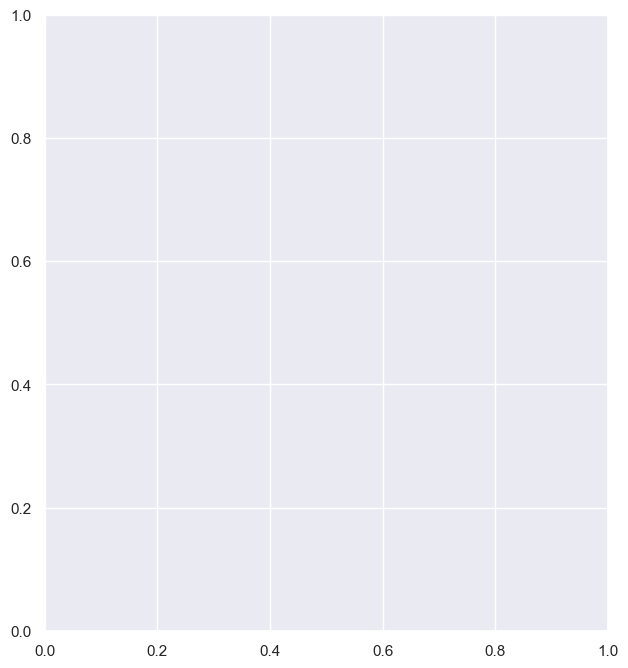

In [ ]:
plot_best_fitting_number_of_clusters(dfChicago_clu_distance_to_city_center_dropoff_scaled, "in dfChicago_dropoff")

### 3.6.2 Computing Clusters with k-means++

In [ ]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_distance_to_city_center_dropoff_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_distance_to_city_center_dropoff_scaled)

# creating a column for the calculated clusters
dfChicago_clu_distance_to_city_center_dropoff.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_distance_to_city_center_dropoff

### 3.6.3 Analyzing & Labeling Clusters

In [ ]:
plot_information_about_clusters(dfChicago_clu_distance_to_city_center_dropoff, ['distance_to_city_center_dropoff'], 'cluster_number')

In [ ]:
dfChicago_clu_distance_to_city_center_dropoff_quantiles = get_quantiles_of_clusters(dfChicago_clu_distance_to_city_center_dropoff, 3, 'cluster_number')
dfChicago_clu_distance_to_city_center_dropoff_quantiles.sort_values(by=['distance_to_city_center_dropoff'], ascending=False)

In [ ]:
label_names = {'0': "Medium Distance from the City Center", 
               '1': "Close to City Center",
               '2': "Far from City Center "
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_distance_to_city_center_dropoff['Cluster_Label'] = dfChicago_clu_distance_to_city_center_dropoff['cluster_number'].astype(str)
dfChicago_clu_distance_to_city_center_dropoff = dfChicago_clu_distance_to_city_center_dropoff.replace({"Cluster_Label": label_names})

dfChicago_clu_distance_to_city_center_dropoff_index = dfChicago_clu_distance_to_city_center_dropoff
dfChicago_clu_distance_to_city_center_dropoff_index['Trip_Index'] = dfChicago_clu_distance_to_city_center_dropoff_index.index
dfChicago_clu_distance_to_city_center_dropoff_index

### 3.6.4 Plotting the Clustering Results

In [ ]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_distance_to_city_center_dropoff_index.sample(n=100_000), x_col='Trip_Index', y_col='distance_to_city_center_dropoff', cluster_col='cluster_number', 
                        label_col="Cluster_Label", size_tuple=(16, 10), dp_size=15, x_label='Trips', y_label="Dropoff Distance to City Center in Miles", 
                        plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in sec combined', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.6.5 Displaying Results on a Map of Chicago

In [ ]:
dfChicago_clu_distance_to_city_center_dropoff_hex_ids = pd.DataFrame(dfChicago_clu_distance_to_city_center_dropoff_index)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_distance_to_city_center_dropoff_hex_ids = pd.concat([dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 
                                                                dfChicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_distance_to_city_center_dropoff_hex_ids

In [ ]:
# create lists of hex ids for each cluster
dropoff_hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 0, 'h3_hex_id_high_res')
dropoff_hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 1, 'h3_hex_id_high_res')
dropoff_hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 2, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_2, color='#2ca02c') 
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_0, color='#ff7f0e', folium_map=m_hex_high_dropoff_distance_city_center) 
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_1, color='#1f77b4', folium_map=m_hex_high_dropoff_distance_city_center)
display(m_hex_high_pickup_distance_city_center)

## 2. Analysis of Spatial Demand & Clusters

### 2.1. Popularity of Community Areas

#### 2.1.1 Preparing Data

In [ ]:
# dictionary with the names of all community areas in chicago
chicago_community_areas = {1: "Rogers Park", 2: "West Ridge", 3: "Uptown", 4: "Lincoln Square", 5: "North Center",6: "Lake View", 7: "Lincoln Park", 8: "Near North Side", 9: "Edison Park", 
                           10: "Norwood Park", 11: "Jefferson Park", 12: "Forest Glen", 13: "North Park", 14: "Albany Park", 15: "Portage Park", 16: "Irving Park", 17: "Dunning", 18: "Montclare", 
                           19: "Belmont Cragin", 20: "Hermosa", 21: "Avondale", 22: "Logan Square", 23: "Humboldt Park", 24: "West Town", 25: "Austin", 26: "West Garfield Park", 
                           27: "East Garfield Park", 28: "Near West Side", 29: "North Lawndale", 30: "South Lawndale", 31: "Lower West Side", 32: "Loop", 33: "Near South Side", 34: "Armour Square", 
                           35: "Douglas", 36: "Oakland", 37: "Fuller Park", 38: "Grand Boulevard", 39: "Kenwood", 40: "Washington Park", 41: "Hyde Park", 42: "Woodlawn", 43: "South Shore", 
                           44: "Chatham", 45: "Avalon Park", 46: "South Chicago", 47: "Burnside", 48: "Calumet Heights", 49: "Roseland", 50: "Pullman", 51: "South Deering", 52: "East Side", 
                           53: "West Pullman", 54: "Riverdale", 55: "Hegewisch", 56: "Garfield Ridge", 57: "Archer Heights", 58: "Brighton Park", 59: "McKinley Park", 60: "Bridgeport", 
                           61: "New City", 62: "West Elsdon", 63: "Gage Park", 64: "Clearing", 65: "West Lawn", 66: "Chicago Lawn", 67: "West Englewood", 68: "Englewood", 
                           69: "Greater Grand Crossing", 70: "Ashburn", 71: "Auburn Gresham", 72: "Beverly", 73: "Washington Heights", 74: "Mount Greenwood", 75: "Morgan Park", 76: "O'Hare", 
                           77: "Edgewater"}


In [ ]:
dfChicago_Community_Areas_Popularity = pd.DataFrame(dfChicago)

# Map community area numbers to names for pickup and dropoff
dfChicago_Community_Areas_Popularity['Pickup_Community_Area_Name'] = dfChicago_Community_Areas_Popularity['Pickup_Community_Area'].map(chicago_community_areas)
dfChicago_Community_Areas_Popularity['Dropoff_Community_Area_Name'] = dfChicago_Community_Areas_Popularity['Dropoff_Community_Area'].map(chicago_community_areas)

dfChicago_Community_Areas_Popularity

In [ ]:
# Calculate the total number of rented taxis for pickups
pickup_counts = dfChicago_Community_Areas_Popularity.groupby('Pickup_Community_Area_Name')['Pickup_Community_Area'].count().reset_index(name='numberOfPickups')

# Sort the DataFrame by 'numberOfRentedTaxis' in ascending order
pickups_sorted = pickup_counts.sort_values(by='numberOfPickups', ascending=False)

# Reset the index and clean up the DataFrame
pickups_sorted.reset_index(drop=True, inplace=True)

pickups_sorted

In [ ]:
# Calculate the total number of rented taxis for pickups
dropoff_counts = dfChicago_Community_Areas_Popularity.groupby('Dropoff_Community_Area_Name')['Dropoff_Community_Area'].count().reset_index(name='numberOfDropoffs')

# Sort the DataFrame by 'numberOfRentedTaxis' in ascending order
dropoffs_sorted = dropoff_counts.sort_values(by='numberOfDropoffs', ascending=False)

# Reset the index and clean up the DataFrame
dropoffs_sorted.reset_index(drop=True, inplace=True)

dropoffs_sorted

In [ ]:
# Merge pickup and dropoff DataFrames
combined_df = pd.merge(pickup_counts, dropoff_counts, left_on='Pickup_Community_Area_Name', right_on='Dropoff_Community_Area_Name', how='outer')

# Fill NaN values with 0 and calculate the combined column
combined_df.fillna(0, inplace=True)
combined_df['Combined'] = combined_df['numberOfPickups'] + combined_df['numberOfDropoffs']

# Drop 'Dropoff_Community_Area_Name' column and rename first column
combined_df.drop(['Dropoff_Community_Area_Name'], axis=1, inplace=True)
combined_df.rename(columns={'Pickup_Community_Area_Name': 'Community_Area_Name'}, inplace=True)

# Sort the DataFrame in descending order based on 'Combined'
Community_Area_Popularity = combined_df.sort_values(by='Combined', ascending=True)

# Reset the index and clean up the DataFrame
Community_Area_Popularity.reset_index(drop=True, inplace=True)

Community_Area_Popularity

### 2.1.2 Plot the Data for Least & Most Popular Stations

#### 2.1.2.1 Visualization of Data for the Most Popular Community Areas in Chicago

In [ ]:
# prepare dataframe combined_stations for plotting
popularity_stations = pd.DataFrame(Community_Area_Popularity)

# set index to station name 
popularity_stations.set_index(['Community_Area_Name'], inplace=True)

# Method to Plot the data
def plot_popularity_stations(popularity, x):
    if popularity == 'most popular':
        ax = popularity_stations.tail(x).plot(kind="barh", figsize=(60,40), fontsize=50, width=0.8)
        ax.set_xlabel('Number of rented bikes', fontsize=60)
        ax.set_ylabel('Station names', fontsize = 60)
        # Prevent scientific notation on the x-axis
        plt.ticklabel_format(style='plain', axis='x')
        ax.set_title(label= str(x) + ' Most Popular Community Areas', fontsize = 80)
        ax.legend(fontsize = 40)
    elif popularity == 'least popular':
        ax = popularity_stations.tail(x).plot(kind="barh", figsize=(60,40), fontsize=50, width=0.8)
        ax.set_xlabel('Number of rented bikes', fontsize=60)
        ax.set_ylabel('Station names', fontsize = 60)
        # Prevent scientific notation on the x-axis
        plt.ticklabel_format(style='plain', axis='x')
        ax.set_title(label= str(x) + ' Least Popular Community Areas', fontsize = 80)
        ax.legend(fontsize = 40)
    else:
        ax = 'Please define the popularity with either "most popular" or "least popular".'
    return ax

In [ ]:
plot_popularity_stations('most popular', 10)
plt.legend(["Number of Pickups", "Number of Dropoffs", "Pickups and Dropoffs Combined"],
    prop={'size': 50})
plt.xlabel("Number of rental activity")
plt.show()

#### 2.1.2.2 Visualization of Data for the Least Popular Community Areas in Chicago

In [ ]:
popularity_stations.sort_values(by=['Combined'], ascending=False, inplace=True)

plot_popularity_stations('least popular', 10)
plt.legend(["Number of Pickups", "Number of Dropoffs", "Pickups and Dropoffs Combined"],
    prop={'size': 50})
plt.xlabel("Number of rental activity")
plt.show()

#### 2.1.2.3 Visualization of Most & Least Popular Community Areas on a Map

In [ ]:
import geopandas as gpd

# Load the GeoJSON file containing Chicago's community area boundaries
# Replace 'path_to_geojson_file.geojson' with the actual file path
geojson_path = '..\data\community_areas.geojson'
gdf = gpd.read_file(geojson_path)

In [ ]:
# Calculate the 5 most and least popular community areas
top_10_popular = Community_Area_Popularity.nlargest(10, 'Combined')
top_10_least_popular = Community_Area_Popularity.nsmallest(10, 'Combined')

# Combine the two DataFrames
highlighted_areas = top_10_popular['Community_Area_Name'].tolist() + top_10_least_popular['Community_Area_Name'].tolist()

highlighted_areas

In [ ]:
# Mapping of Community Area Names to GeoJSON Names
mapping = {
    'Near North Side': 'NEAR NORTH SIDE',
    'Loop': 'LOOP',
    'Lake View': 'LAKE VIEW',
    'Near West Side': 'NEAR WEST SIDE',
    'Lincoln Park': 'LINCOLN PARK',
    'West Town': 'WEST TOWN',
    'Near South Side': 'NEAR SOUTH SIDE',
    'Uptown': 'UPTOWN',
    'Logan Square': 'LOGAN SQUARE',
    'Edgewater': 'EDGEWATER',
    'Riverdale': 'RIVERDALE',
    'Hegewisch': 'HEGEWISCH',
    'East Side': 'EAST SIDE',
    'West Pullman': 'WEST PULLMAN',
    'Burnside': 'BURNSIDE',
    'Pullman': 'PULLMAN',
    'Mount Greenwood': 'MOUNT GREENWOOD',
    'South Deering': 'SOUTH DEERING',
    'Morgan Park': 'MORGAN PARK',
    'Beverly': 'BEVERLY'
}

In [ ]:
m = folium.Map(location=map_center, zoom_start=10, tiles='cartodbpositron')

# Define the style function for the GeoJSON layer
def style_function(feature):
    geojson_community = feature['properties']['community']
    if any(name in geojson_community for name in mapping.values()):
        matched_name = next(name for name, geojson_name in mapping.items() if geojson_name in geojson_community)
        if matched_name in top_10_least_popular['Community_Area_Name'].tolist():
            return {
                'color': 'red',      # Least popular areas in red
                'weight': 4,         # Border weight for highlighted areas
                'fillOpacity': 0.1   # Fill opacity for highlighted areas
            }
        elif matched_name in top_10_popular['Community_Area_Name'].tolist():
            return {
                'color': 'green',    # Most popular areas in green
                'weight': 4,         # Border weight for highlighted areas
                'fillOpacity': 0.1   # Fill opacity for highlighted areas
            }
    return {
        'color': 'blue',         # Border color for non-highlighted areas
        'weight': 2,             # Border weight for non-highlighted areas
        'fillOpacity': 0         # No fill
    }

# Add GeoJSON layer for community area boundaries
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['community'],  # Field(s) from GeoJSON properties to display
        aliases=['Community Area'],  # Alias for field(s)
        localize=True  # If True, format numbers and dates according to the browser locale
    )
).add_to(m)

# Show the map
m

### 2.2 Location Clusters

### 2.2.1 Feature Selection -  Pickups


In [ ]:
# Feature selection
dfChicago_clu_pickups = dfChicago[['Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude']]
dfChicago_clu_pickups

In [ ]:
# Scaling the data
dfChicago_clu_pickups_scaled = scaling_data(dfChicago_clu_pickups)

### 2.2.2 Validation of Number of Clusters

In [ ]:
plot_best_fitting_number_of_clusters(dfChicago_clu_pickups_scaled, "in dfChicago_clu_pickups")

### 2.2.3 Computing Clusters with KMeans

In [ ]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=4,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_pickups_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_pickups_scaled)

# creating a column for the calculated clusters

dfChicago_clu_pickups.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_pickups

### 2.2.4 Analyzing Clusters & Labeling them

In [ ]:
plot_information_about_clusters(dfChicago_clu_pickups, ['Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude'], 'cluster_number')

In [ ]:
label_names = {'0': "Evening Commuters", 
               '1': "Short to Medium Rides (2 - 4 Miles)",
               '2': "Long Rides (7 - 11 miles)",
               '3': "Party People / Night Riders"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_pickups['Cluster_Label'] = dfChicago_clu_pickups['cluster_number'].astype(str)
dfChicago_clu_pickups = dfChicago_clu_pickups.replace({"Cluster_Label": label_names})

#dfChicago_clu_distance_city_center_pickup_index = dfChicago_clu_distance_city_center_pickup
#dfChicago_clu_distance_city_center_pickup_index['Trip_Index'] = dfChicago_clu_distance_city_center_pickup_index.index
#dfChicago_clu_distance_city_center_pickup_index

### 2.2.5 Plotting the Clustering Results

In [ ]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_pickups.sample(n=1_000_000), x_col='Pickup_Centroid_Latitude', y_col='Pickup_Centroid_Longitude', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Latitude', y_label="Longitude", plot_title='Scatter Plot of Clustered Pickup Locations',
                        leg_loc='lower center', anchor=(0.5, -0.25))

### 2.2.7 Displaying Results on a Map of Chicago

In [ ]:
dfChicago_clu_pickups_hex_ids = pd.DataFrame(dfChicago_clu_pickups)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_pickups_hex_ids = pd.concat([dfChicago_clu_pickups_hex_ids, 
                                                                dfChicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_pickups_hex_ids

In [ ]:
# create lists of hex ids for each cluster
pickups_hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_pickups_hex_ids, 0, 'h3_hex_id_high_res')
pickups_hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_pickups_hex_ids, 1, 'h3_hex_id_high_res')
pickups_hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_pickups_hex_ids, 2, 'h3_hex_id_high_res')
pickups_hex_ids_for_cluster_3 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_pickups_hex_ids, 3, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_pickups_distance_city_center = visualize_hexagons(pickups_hex_ids_for_cluster_0, color='#2ca02c') 
m_hex_high_pickups_distance_city_center = visualize_hexagons(pickups_hex_ids_for_cluster_1, color='#ff7f0e', folium_map=m_hex_high_pickups_distance_city_center) 
m_hex_high_pickups_distance_city_center = visualize_hexagons(pickups_hex_ids_for_cluster_2, color='#1f77b4', folium_map=m_hex_high_pickups_distance_city_center)
m_hex_high_pickups_distance_city_center = visualize_hexagons(pickups_hex_ids_for_cluster_3, color='#d62728', folium_map=m_hex_high_pickups_distance_city_center)

# Define a function to style the GeoJSON layer
def style_function(feature):
    return {
        'fillColor': 'none',     # No fill color
        'color': '#CCCCCC',        # Border color
        'weight': 2              # Border weight
    }

# Add GeoJSON layer for community area boundaries with the specified style
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['community'],  # Field(s) from GeoJSON properties to display
        aliases=['Community Area'],  # Alias for field(s)
        localize=True  # If True, format numbers and dates according to the browser locale
    )
).add_to(m_hex_high_pickups_distance_city_center)

display(m_hex_high_pickups_distance_city_center)